#Prepare data

Notebook này thực hiện nhiệm vụ:
- Chuẩn bị dữ liệu code description từ bỗ dữ liệu MIMIC và ICD API
- Tăng cường mã chẩn đoán ICD9 trong bộ dữ liệu MIMIC
- Phân tích đặc tính dữ liệu: note lenght, token lenght, code length

In [ ]:
!pip install -q datasets==3.4.1
!pip install sacremoses
!git clone https://github.com/chancholat/mimic.git
!mkdir /content/src
!gdown --folder https://drive.google.com/drive/folders/1b3tBwPYlPx0j-3pdJy4Na6wQBZUTJezv -O /content/src

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.

In [ ]:
import kagglehub
#Download the latest version.
kagglehub.dataset_download('chanhainguyen/thesis-data-process')

'/kaggle/input/thesis-data-process'

In [ ]:
!mkdir mimic/data
# !mv /root/.cache/kagglehub/datasets/chanhainguyen/thesis-data-process/versions/1/processed /content/mimic/data
!mv /kaggle/input/thesis-data-process/processed /content/mimic/data

mv: cannot remove '/kaggle/input/thesis-data-process/processed/mdace_icd9_inpatient_code/train.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mdace_icd9_inpatient_code/test.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mdace_icd9_inpatient_code/val.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mimiciv_icd9/train.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mimiciv_icd9/test.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mimiciv_icd9/val.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mdace_notes.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/mimiciii_50/train.parquet': Read-only file system
mv: cannot remove '/kaggle/input/thesis-data-process/processed/

### Load MIMIC

In [ ]:
%cd /content/
from datasets import load_dataset
from pathlib import Path
# SIZE = 10
# mimic = load_dataset(str(dataset_path), split=f"train[:{SIZE}]", trust_remote_code=True)
dataset_path = Path("mimic/mdace_inpatient_icd9_code.py")
mimic = load_dataset(str(dataset_path), trust_remote_code=True)

/content


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

### Load MDACE

In [ ]:
from datasets import load_dataset
from pathlib import Path
dataset_path = Path("mimic/mdace_inpatient_icd9.py")
mdace = load_dataset(str(dataset_path), trust_remote_code=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Dataset Analyse

In [ ]:
import pandas as pd

# Load the Parquet file
train_code_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_code/train.parquet")
val_code_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_code/val.parquet")
test_code_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_code/test.parquet")

train_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient/train.parquet")
val_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient/val.parquet")
test_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient/test.parquet")

train_icd10_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd10_inpatient/train.parquet")
val_icd10_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd10_inpatient/val.parquet")
test_icd10_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd10_inpatient/test.parquet")

full_train_df = pd.read_parquet("/content/mimic/data/processed/mimiciii_full/train.parquet")
full_val_df = pd.read_parquet("/content/mimic/data/processed/mimiciii_full/val.parquet")
full_test_df = pd.read_parquet("/content/mimic/data/processed/mimiciii_full/test.parquet")

clean_train_df = pd.read_parquet("/content/mimic/data/processed/mimiciii_clean/train.parquet")
clean_val_df = pd.read_parquet("/content/mimic/data/processed/mimiciii_clean/val.parquet")
clean_test_df = pd.read_parquet("/content/mimic/data/processed/mimiciii_clean/test.parquet")

### Dataset Overview

In [ ]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

def get_all_codes(df, column_name='diagnosis_codes'):
    all_codes = [
    code
    for sublist in df[column_name]
    if sublist is not None
    for code in sublist
    ]
    return all_codes

def analyse_codes(df, column_name="diagnosis_codes", plot=True, min_max=True):
  # Sample structure
  # df = pd.DataFrame({column_name: [['A01', 'B02'], ['A01'], ['C03', 'A01'], [], ['B02']]})

  # 1. Total number of codes (all rows combined), pations, documents
  all_codes = get_all_codes(df, column_name)

  num_total_codes = len(all_codes)
  print(f"Total number of:\t medical codes: {num_total_codes},\t docs: {df['note_id'].nunique()},\t patients: {df['subject_id'].nunique()}")


  # 2. Distribution of codes (frequency)
  code_counter = Counter(all_codes)

  num_unique_codes = len(code_counter)
  print(f"Number of different medical codes: {num_unique_codes}")

  # print("\nCode distribution (frequency):")
  # print(code_counter)
  # Convert to DataFrame for sorting
  freq_df = pd.DataFrame(code_counter.items(), columns=["code", "count"]).sort_values(by="count", ascending=False)

  if plot:
    # Plot
    plt.figure(figsize=(6, 3))
    plt.bar(range(len(freq_df)), freq_df['count'])

    # Remove x-axis labels (as requested)
    plt.xticks([])

    plt.ylabel("Frequency")
    plt.title("Distribution of Medical Codes")
    plt.tight_layout()
    plt.show()

  if min_max:
    # 3. Top most frequent codes
    top_most = code_counter.most_common(10)
    print("\nTop 10 most frequent codes:")
    for code, count in top_most:
        print(f"{code}: {count}")

    # 4. Least frequent codes
    least_common = code_counter.most_common()[:-11:-1]  # last 10
    print("\nTop 10 least frequent codes:")
    for code, count in least_common:
        print(f"{code}: {count}")

In [ ]:
print("MDACE ICD9 codes")
analyse_codes(train_code_df, plot=False, min_max=False)
analyse_codes(val_code_df, plot=False, min_max=False)
analyse_codes(test_code_df, plot=False, min_max=False)

print("\nMDACE ICD9 ")
analyse_codes(train_df, plot=False, min_max=False)
analyse_codes(val_df, plot=False, min_max=False)
analyse_codes(test_df, plot=False, min_max=False)

print("\nMIMIC III FULL")
analyse_codes(full_train_df, plot=False, min_max=False)
analyse_codes(full_val_df, plot=False, min_max=False)
analyse_codes(full_test_df, plot=False, min_max=False)

MDACE ICD9 codes
Total number of:	 medical codes: 549845,	 docs: 48074,	 patients: 37173
Number of different medical codes: 6741
Total number of:	 medical codes: 23313,	 docs: 1753,	 patients: 1434
Number of different medical codes: 2394
Total number of:	 medical codes: 44938,	 docs: 3197,	 patients: 2578
Number of different medical codes: 3105

MDACE ICD9 
Total number of:	 medical codes: 2009,	 docs: 355,	 patients: 176
Number of different medical codes: 636
Total number of:	 medical codes: 644,	 docs: 122,	 patients: 60
Number of different medical codes: 289
Total number of:	 medical codes: 639,	 docs: 127,	 patients: 61
Number of different medical codes: 305

MIMIC III FULL
Total number of:	 medical codes: 547836,	 docs: 47719,	 patients: 36997
Number of different medical codes: 6724
Total number of:	 medical codes: 22669,	 docs: 1631,	 patients: 1374
Number of different medical codes: 2363
Total number of:	 medical codes: 48437,	 docs: 3372,	 patients: 2755
Number of different med

In [ ]:
import numpy as np
print(len(train_code_df), (train_code_df['diagnosis_code_spans'].apply(lambda x: isinstance(x, np.ndarray) and x.shape != (1,))).sum())
print(len(val_code_df), (val_code_df['diagnosis_code_spans'].apply(lambda x: isinstance(x, np.ndarray) and x.shape != (1,))).sum())
print(len(test_code_df), (test_code_df['diagnosis_code_spans'].apply(lambda x: isinstance(x, np.ndarray) and x.shape != (1,))).sum())
print(len(train_df), (train_df['diagnosis_code_spans'].apply(lambda x: isinstance(x, np.ndarray) and x.shape != (1,))).sum())
print(len(val_df), (val_df['diagnosis_code_spans'].apply(lambda x: isinstance(x, np.ndarray) and x.shape != (1,))).sum())
print(len(test_df), (test_df['diagnosis_code_spans'].apply(lambda x: isinstance(x, np.ndarray) and x.shape != (1,))).sum())

48074 227
1753 74
3197 82
355 227
122 74
127 82


Total number of:	 medical codes: 549845,	 docs: 48074,	 patients: 37173
Number of different medical codes: 6741


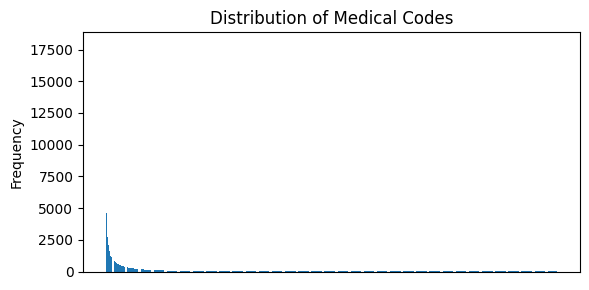


Top 10 most frequent codes:
401.9: 17963
428.0: 11744
427.31: 11374
414.01: 11033
584.9: 7947
250.00: 7921
272.4: 7079
518.81: 6509
599.0: 5786
530.81: 5399

Top 10 least frequent codes:
719.70: 1
143.0: 1
823.42: 1
V44.9: 1
973.3: 1
E858.4: 1
969.71: 1
E900.1: 1
852.56: 1
V61.10: 1
Total number of:	 medical codes: 2009,	 docs: 355,	 patients: 176
Number of different medical codes: 636


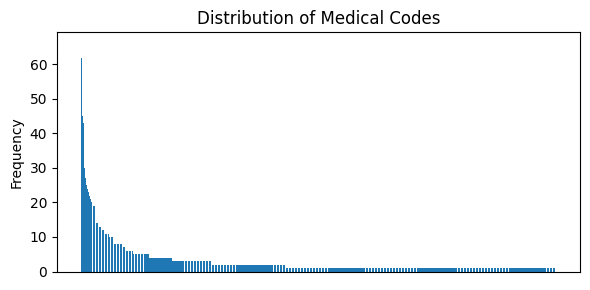


Top 10 most frequent codes:
401.9: 66
272.4: 62
427.31: 45
V15.82: 43
414.01: 43
311: 30
530.81: 27
458.9: 25
285.9: 25
250.00: 24

Top 10 least frequent codes:
421.0: 1
V10.02: 1
070.70: 1
241.0: 1
595.0: 1
403.00: 1
715.16: 1
442.83: 1
575.8: 1
782.4: 1


In [ ]:
analyse_codes(train_code_df, plot=True, min_max=True)
analyse_codes(train_df, plot=True, min_max=True)

###(Old) Select Rare Code

In [ ]:
import numpy as np

def get_tail_codes(df, column_name='diagnosis_codes', tail_percent=10):
  # 1. Total number of codes (all rows combined)
  all_codes = get_all_codes(df, column_name)

  # 2. Distribution of codes (frequency)
  code_counter = Counter(all_codes)
  # Get code frequencies as a list
  freqs = np.array(list(code_counter.values()))

  # Define a percentile threshold for "tail" (e.g., bottom 10%)
  threshold = np.percentile(freqs, tail_percent)  # 10th percentile
  # Get codes with frequency less than or equal to the threshold
  tail_codes = [code for code, count in code_counter.items() if count <= threshold]
  return tail_codes, all_codes

In [ ]:
tail_percent=tail_percent = 10
train_code_tail_codes, train_code_all_codes = get_tail_codes(train_code_df, tail_percent=tail_percent)
test_code_tail_codes, test_code_all_codes = get_tail_codes(test_code_df, tail_percent=tail_percent)
val_code_tail_codes, val_code_all_codes = get_tail_codes(val_code_df, tail_percent=tail_percent)
union_code_all_codes = set(train_code_all_codes).union(set(test_code_all_codes)).union(set(val_code_all_codes))
union_code_tail_codes = set(train_code_tail_codes).union(set(test_code_tail_codes)).union(set(val_code_tail_codes))
print("mdace_code:")
print(f"tail codes: train: {len(train_code_tail_codes)}, test: {len(test_code_tail_codes)}, val: {len(val_code_tail_codes)}, union tail codes: {len(union_code_tail_codes)}")
print(f"all codes: train: {len(train_code_all_codes)}, test: {len(test_code_all_codes)}, val: {len(val_code_all_codes)}, union all codes: {len(union_code_all_codes)}")
print(f"rare code rate: {len(union_code_tail_codes)/len(union_code_all_codes)}, rare thresold: {tail_percent}%")

train_tail_codes, train_all_codes = get_tail_codes(train_df, tail_percent=tail_percent)
test_tail_codes, test_all_codes = get_tail_codes(test_df, tail_percent=tail_percent)
val_tail_codes, val_all_codes = get_tail_codes(val_df, tail_percent=tail_percent)
mdace_uion_tail_codes = set(train_tail_codes).union(set(test_tail_codes)).union(set(val_tail_codes))
mdace_union_all_codes = set(train_all_codes).union(set(test_all_codes)).union(set(val_all_codes))
print("mdace:")
print(f"tail code: train: {len(train_tail_codes)}, test: {len(test_tail_codes)}, val: {len(val_tail_codes)}, union tail codes: {len(mdace_uion_tail_codes)}")
print(f"all codes: train: {len(train_all_codes)}, test: {len(test_all_codes)}, val: {len(val_all_codes)}, union all codes: {len(mdace_union_all_codes)}")
print(f"rare code rate: {len(mdace_uion_tail_codes)/len(mdace_union_all_codes)}, rare thresold: {tail_percent}%")

print()
intersec_tail_codes = set(union_code_tail_codes).intersection(set(mdace_uion_tail_codes))
print("intersection tail: ", len(intersec_tail_codes))
print(intersec_tail_codes)

mdace_code:
tail codes: train: 1530, test: 1100, val: 925, union tail codes: 3161
all codes: train: 549845, test: 44938, val: 23313, union all codes: 6932
rare code rate: 0.45600115406809, rare thresold: 10%
mdace:
tail code: train: 361, test: 199, val: 174, union tail codes: 639
all codes: train: 2009, test: 639, val: 644, union all codes: 828
rare code rate: 0.7717391304347826, rare thresold: 10%

intersection tail:  145
{'171.5', '726.0', '555.1', '372.73', '516.0', '702.19', '742.9', '441.3', '715.14', '294.21', '313.89', '721.2', 'E901.0', '560.0', '323.41', '853.05', '808.42', '250.51', '695.10', '813.80', '814.00', '341.9', '575.8', '965.1', '424.90', '565.1', '289.50', '265.1', '237.3', 'E819.9', '593.4', '337.3', 'E860', '459.89', '357.9', '214.0', '510.0', '442.83', '336.0', '369.66', '958.92', '355.1', '967.8', '427.9', '259.4', '305.62', '524.61', '239.6', '540.1', '277.4', '397.9', '823.21', '209.30', '952.9', 'V54.16', '338.4', '446.5', '158.0', '204.02', '805.05', '246.9

In [ ]:
# Filter rows where at least one code is in rare_codes
def filter_rare_codes(df, rare_codes):
  mask = df["diagnosis_codes"].apply(lambda codes: any(code in rare_codes for code in codes))
  filtered_df = df[mask].reset_index(drop=True)
  return filtered_df

rare_train_codes = filter_rare_codes(train_df, mdace_uion_tail_codes)
rare_test_codes = filter_rare_codes(test_df, mdace_uion_tail_codes)
rare_val_codes = filter_rare_codes(val_df, mdace_uion_tail_codes)


!mkdir /content/mimic/data/processed/mdace_icd9_inpatient_rare
rare_train_codes.to_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_rare/train.parquet", index=False)
rare_test_codes.to_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_rare/test.parquet", index=False)
rare_val_codes.to_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_rare/val.parquet", index=False)

In [ ]:
rare_train_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_rare/train.parquet")
rare_val_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_rare/val.parquet")
rare_test_df = pd.read_parquet("/content/mimic/data/processed/mdace_icd9_inpatient_rare/test.parquet")

In [ ]:
test_rare_codes = set(get_all_codes(rare_train_df)).union(set(get_all_codes(rare_val_df))).union(set(get_all_codes(rare_test_df)))
print(len(test_rare_codes))
print(test_rare_codes)
print(mdace_uion_tail_codes)

826
{'171.5', '320.2', '799.1', '288.66', '571.5', '038.11', 'V46.2', '715.14', '823.30', '070.54', '995.92', '313.89', 'V85.42', 'V09.91', '278.00', 'V12.04', 'V58.65', '531.40', '340', '272.6', 'V15.82', '552.21', '415.11', 'E884.6', '284.19', 'V15.51', '571.8', '569.83', '852.26', '112.2', '565.1', '348.4', '237.3', '574.10', '535.01', '593.4', '344.04', '337.3', '780.61', 'V10.83', '403.90', '357.9', '802.4', 'E878.6', '336.0', '958.92', '737.10', '793.99', 'V58.61', 'V45.72', '041.04', '967.8', '294.10', '524.61', '239.6', '540.1', '276.50', '784.2', '410.41', '574.91', '724.00', '707.21', 'V58.63', '747.69', '536.3', '008.45', 'E884.2', '802.6', '714.0', '736.79', '038.9', '204.02', '789.59', '737.39', '553.29', '511.81', '852.01', '369.8', 'E816.0', '426.53', 'E883.0', '277.88', '280.9', '507.0', '348.2', '733.22', '790.7', '211.3', '241.0', '441.2', '427.1', 'E858.8', '487.0', '562.10', '053.19', '816.00', '171.9', '314.01', '785.52', '263.0', '514', '783.41', '680.6', '491.22'

In [ ]:
mimiciv_icd9_train_df = pd.read_parquet("/content/mimic/data/processed/mimiciv_icd9/train.parquet")
mimiciv_icd9_val_df = pd.read_parquet("/content/mimic/data/processed/mimiciv_icd9/val.parquet")
mimiciv_icd9_test_df = pd.read_parquet("/content/mimic/data/processed/mimiciv_icd9/test.parquet")
mimiciv_icd10_train_df = pd.read_parquet("/content/mimic/data/processed/mimiciv_icd10/train.parquet")
mimiciv_icd10_val_df = pd.read_parquet("/content/mimic/data/processed/mimiciv_icd10/val.parquet")
mimiciv_icd10_test_df = pd.read_parquet("/content/mimic/data/processed/mimiciv_icd10/test.parquet")

KeyboardInterrupt: 

In [ ]:
#print length of these df
print(len(mimiciv_icd9_train_df), len(mimiciv_icd9_val_df), len(mimiciv_icd9_test_df))
print(len(mimiciv_icd10_train_df), len(mimiciv_icd10_val_df), len(mimiciv_icd10_test_df))

### Data structure overview

In [ ]:
import pandas as pd
import numpy as np

def overview_mdace_stats(df, verbose=False, isFull=False):
    stats = {}

    # Total rows
    stats['Total rows'] = len(df)

    # Total different subject_id
    stats['Total unique subject_id'] = df['subject_id'].nunique()

    # Total unique codes in diagnosis_codes and procedure_codes
    stats['Unique diagnosis_codes'] = df['diagnosis_codes'].explode().nunique()
    stats['Unique procedure_codes'] = df['procedure_codes'].explode().nunique()

    # Total diagnosis_code_spans that are not empty (assuming it's a list or string)
    if not isFull:
      stats['Non-empty diagnosis_code_spans'] = df['diagnosis_code_spans'].apply(lambda x: isinstance(x, np.ndarray) and x.shape != (1,)).sum()
      stats['Non-empty procedure_code_spans'] = df['procedure_code_spans'].apply(lambda x: isinstance(x, np.ndarray) and x.shape != (1,)).sum()


    # Count note_type
    # stats['Number of Discharge summary notes'] = (df['note_type'] == 'Discharge summary').sum()
    # stats['Number of Physician notes'] = (df['note_type'] == 'Physician ').sum()
    unique_note_types = df["note_type"].unique()
    for note_type in unique_note_types:
      stats[f"Number of {note_type} notes"] = (df['note_type'] == note_type).sum()
    # Display results
    if verbose:
      for k, v in stats.items():
          print(f"{k}: {v}")

      for note_type in unique_note_types:
          print(f"Number of {note_type} notes: {stats[f'Number of {note_type} notes']}")
    return stats

In [ ]:
train_code_stats = overview_mdace_stats(train_code_df)
val_code_stats = overview_mdace_stats(val_code_df)
test_code_stats = overview_mdace_stats(test_code_df)

In [ ]:
train_stats = overview_mdace_stats(train_df)
val_stats = overview_mdace_stats(val_df)
test_stats = overview_mdace_stats(test_df)

In [ ]:
# Combine into a comparison table
summary_code_df = pd.DataFrame({
    'Train': train_code_stats,
    'Validation': val_code_stats,
    'Test': test_code_stats
}).T  # Transpose for readability

# Display
(summary_code_df)

,Total rows,Total unique subject_id,Unique diagnosis_codes,Unique procedure_codes,Non-empty diagnosis_code_spans,Non-empty procedure_code_spans,Number of Discharge summary notes,Number of Physician notes,Number of General notes,Number of Radiology notes,Number of Nutrition notes,Number of Rehab Services notes,Number of Nursing notes,Number of Case Management notes,Number of Respiratory notes,Number of ECG notes,Number of Consult notes
Train,48074.0,37173.0,6741.0,1971.0,227.0,40.0,47904.0,130.0,8.0,13.0,7.0,3.0,1.0,1.0,7.0,NaN,NaN
Validation,1753.0,1434.0,2394.0,650.0,74.0,10.0,1692.0,40.0,4.0,11.0,1.0,2.0,NaN,NaN,3.0,NaN,NaN
Test,3197.0,2578.0,3105.0,875.0,82.0,15.0,3132.0,41.0,5.0,11.0,3.0,NaN,NaN,NaN,2.0,1.0,2.0


In [ ]:
# Combine into a comparison table
summary_df = pd.DataFrame({
    'Train': train_stats,
    'Validation': val_stats,
    'Test': test_stats
}).T  # Transpose for readability

# Display
(summary_df)

,Total rows,Total unique subject_id,Unique diagnosis_codes,Unique procedure_codes,Non-empty diagnosis_code_spans,Non-empty procedure_code_spans,Number of Physician notes,Number of Discharge summary notes,Number of Radiology notes,Number of Case Management notes,Number of General notes,Number of Nutrition notes,Number of Rehab Services notes,Number of Nursing notes,Number of Respiratory notes,Number of ECG notes,Number of Consult notes
Train,355.0,176.0,636.0,71.0,227.0,40.0,130.0,185.0,13.0,1.0,8.0,7.0,3.0,1.0,7.0,NaN,NaN
Validation,122.0,60.0,289.0,24.0,74.0,10.0,40.0,61.0,11.0,NaN,4.0,1.0,2.0,NaN,3.0,NaN,NaN
Test,127.0,61.0,305.0,40.0,82.0,15.0,41.0,62.0,11.0,NaN,5.0,3.0,NaN,NaN,2.0,1.0,2.0


In [ ]:
train_icd10_stats = overview_mdace_stats(train_icd10_df)
val_icd10_stats = overview_mdace_stats(val_icd10_df)
test_icd10_stats = overview_mdace_stats(test_icd10_df)

In [ ]:
# Combine into a comparison table
summary_icd10_df = pd.DataFrame({
    'Train': train_icd10_stats,
    'Validation': val_icd10_stats,
    'Test': test_icd10_stats
}).T  # Transpose for readability

# Display
(summary_icd10_df)

,Total rows,Total unique subject_id,Unique diagnosis_codes,Unique procedure_codes,Non-empty diagnosis_code_spans,Non-empty procedure_code_spans,Number of Discharge summary notes,Number of Respiratory notes,Number of Physician notes,Number of Nutrition notes,Number of General notes,Number of Rehab Services notes,Number of Nursing notes,Number of Case Management notes,Number of Radiology notes,Number of ECG notes,Number of Consult notes
Train,354.0,176.0,681.0,87.0,228.0,42.0,185.0,7.0,129.0,7.0,8.0,3.0,1.0,1.0,13.0,NaN,NaN
Validation,122.0,60.0,294.0,31.0,74.0,11.0,61.0,3.0,40.0,1.0,4.0,2.0,NaN,NaN,11.0,NaN,NaN
Test,127.0,61.0,319.0,43.0,82.0,15.0,62.0,2.0,41.0,3.0,5.0,NaN,NaN,NaN,11.0,1.0,2.0


In [ ]:
full_train_stats = overview_mdace_stats(full_train_df, isFull=True)
full_val_stats = overview_mdace_stats(full_val_df, isFull=True)
full_test_stats = overview_mdace_stats(full_test_df, isFull=True)

In [ ]:
# Combine into a comparison table
full_summary_df = pd.DataFrame({
    'Train': full_train_stats,
    'Validation': full_val_stats,
    'Test': full_test_stats
}).T  # Transpose for readability

# Display
(full_summary_df)

,Total rows,Total unique subject_id,Unique diagnosis_codes,Unique procedure_codes,Number of Discharge summary notes
Train,47719,36997,6724,1968,47719
Validation,1631,1374,2363,649,1631
Test,3372,2755,3178,907,3372


In [ ]:
clean_train_stats = overview_mdace_stats(clean_train_df, isFull=True)
clean_val_stats = overview_mdace_stats(clean_val_df, isFull=True)
clean_test_stats = overview_mdace_stats(clean_test_df, isFull=True)

In [ ]:
# Combine into a comparison table
clean_summary_df = pd.DataFrame({
    'Train': clean_train_stats,
    'Validation': clean_val_stats,
    'Test': clean_test_stats
}).T  # Transpose for readability

# Display
(clean_summary_df)

,Total rows,Total unique subject_id,Unique diagnosis_codes,Unique procedure_codes,Number of Discharge summary notes
Train,38401,30033,2849,832,38401
Validation,5577,4544,2844,832,5577
Test,8734,6541,2849,832,8734


### Load Real reated note ids

In [ ]:
from datasets import load_dataset

match_note_id = load_dataset("ChanBeDu/augmented_icd9_note_id_full")

README.md:   0%|          | 0.00/866 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/10.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3019 [00:00<?, ? examples/s]

In [ ]:
%cd /content/
from datasets import load_dataset
from pathlib import Path
# SIZE = 10
mdace_path = Path("mimic/mdace_inpatient_icd9.py")
mdace = load_dataset(str(mdace_path), trust_remote_code=True)
mimic_path = Path("mimic/mdace_inpatient_icd9_code.py")
mimic = load_dataset(str(mimic_path), trust_remote_code=True)

/content


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# Extract note_ids from dataset_a
note_ids_to_keep = set([ids[0] for ids in match_note_id['train']["match_note_id"] if ids] )

# Filter dataset_b to keep only rows with note_id in dataset_a
match_mdace = mdace['train'].filter(lambda x: x["note_id"] in note_ids_to_keep)

# Check result
print(len(match_mdace))

Filter:   0%|          | 0/355 [00:00<?, ? examples/s]

128


In [ ]:
# Extract note_ids from dataset_a
note_ids_to_keep = set([ids[0] for ids in match_note_id['train']["match_note_id"] if ids] )

# Filter dataset_b to keep only rows with note_id in dataset_a
match_mimic = mimic['train'].filter(lambda x: x["note_id"] in note_ids_to_keep)

# Check result
print(len(match_mimic))

Filter:   0%|          | 0/48074 [00:00<?, ? examples/s]

2117


In [ ]:
match_mimic_stats = overview_mdace_stats(match_mimic.to_pandas())
(match_mimic_stats)

{'Total rows': 2117,
 'Total unique subject_id': 2017,
 'Unique diagnosis_codes': 2886,
 'Unique procedure_codes': 789,
 'Non-empty diagnosis_code_spans': np.int64(125),
 'Non-empty procedure_code_spans': np.int64(26),
 'Number of Discharge summary notes': np.int64(2106),
 'Number of Physician  notes': np.int64(10),
 'Number of Nutrition notes': np.int64(1)}

### Overview envidence

In [ ]:
%cd /content/
from datasets import load_dataset
from pathlib import Path
# SIZE = 10
# mimic = load_dataset(str(dataset_path), split=f"train[:{SIZE}]", trust_remote_code=True)
dataset_path = Path("mimic/mdace_inpatient_icd9.py")
mdace = load_dataset(str(dataset_path), trust_remote_code=True)

/content


In [ ]:
from datasets import Dataset
import re

# Normalize headings to lowercase for matching
# heading_patterns = [re.escape(h.lower()) for h in common_headings]
heading_patterns = common_headings  ## Run cell" build common phrases" below


# Precompile regex to search for all headings
heading_regex = re.compile(r"|".join(heading_patterns), flags=re.IGNORECASE)

def find_nearest_heading(exmaple):
    text = exmaple["text"]
    dx_span_list = exmaple["diagnosis_code_spans"]
    pcs_span_list = exmaple["procedure_code_spans"]
    headings = [(m.start(), m.group()) for m in heading_regex.finditer(text)]
    headings.sort()

    dx_section_labels = []
    pcs_section_labels = []

    for span in dx_span_list:

        if not span[0]:  # handle empty inner list
            dx_section_labels.append(None)
            continue

        # Get the start position of the current span
        start_pos = span[0][0]

        # Find the closest heading before the span
        found = None
        for pos, label in reversed(headings):
            if pos <= start_pos:
                found = label
                break

        dx_section_labels.append(found)


    for span in pcs_span_list:
        if not span[0]:  # handle empty inner list
            pcs_section_labels.append(None)
            continue

        # Get the start position of the current span
        start_pos = span[0][0]

        # Find the closest heading before the span
        found = None
        for pos, label in reversed(headings):
            if pos <= start_pos:
                found = label
                break

        pcs_section_labels.append(found)

    return {
        "dx_span_section": dx_section_labels,
        "pcs_span_section": pcs_section_labels
        }

In [ ]:

# Assuming your dataset is named `dataset`
# mdace_span_heading = mdace.map(find_nearest_heading)
mdace_span_heading = match_mdace.map(find_nearest_heading)

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert dataset to DataFrame
# df = mdace_span_heading['train'].to_pandas()
df = mdace_span_heading.to_pandas()

# Flatten all labels in dx_span_section and pcs_span_section
dx_sections = [label for sublist in df["dx_span_section"] for label in sublist if label]
pcs_sections = [label for sublist in df["pcs_span_section"] for label in sublist if label]

In [ ]:
from collections import Counter
def section_frequency(sections):
  section_freq = Counter(sections)

  # Convert to DataFrame for plotting
  freq_df = pd.DataFrame(section_freq.items(), columns=["Section", "Frequency"])
  freq_df = freq_df.sort_values(by="Frequency", ascending=False)

  plt.figure(figsize=(12, 8))
  plt.barh(freq_df["Section"], freq_df["Frequency"], color="skyblue")
  plt.xlabel("Frequency")
  plt.ylabel("Section Heading")
  plt.yticks(fontsize=8)
  plt.title("Frequency of Span Headings")
  plt.gca().invert_yaxis()  # Highest at top
  plt.tight_layout()
  plt.show()

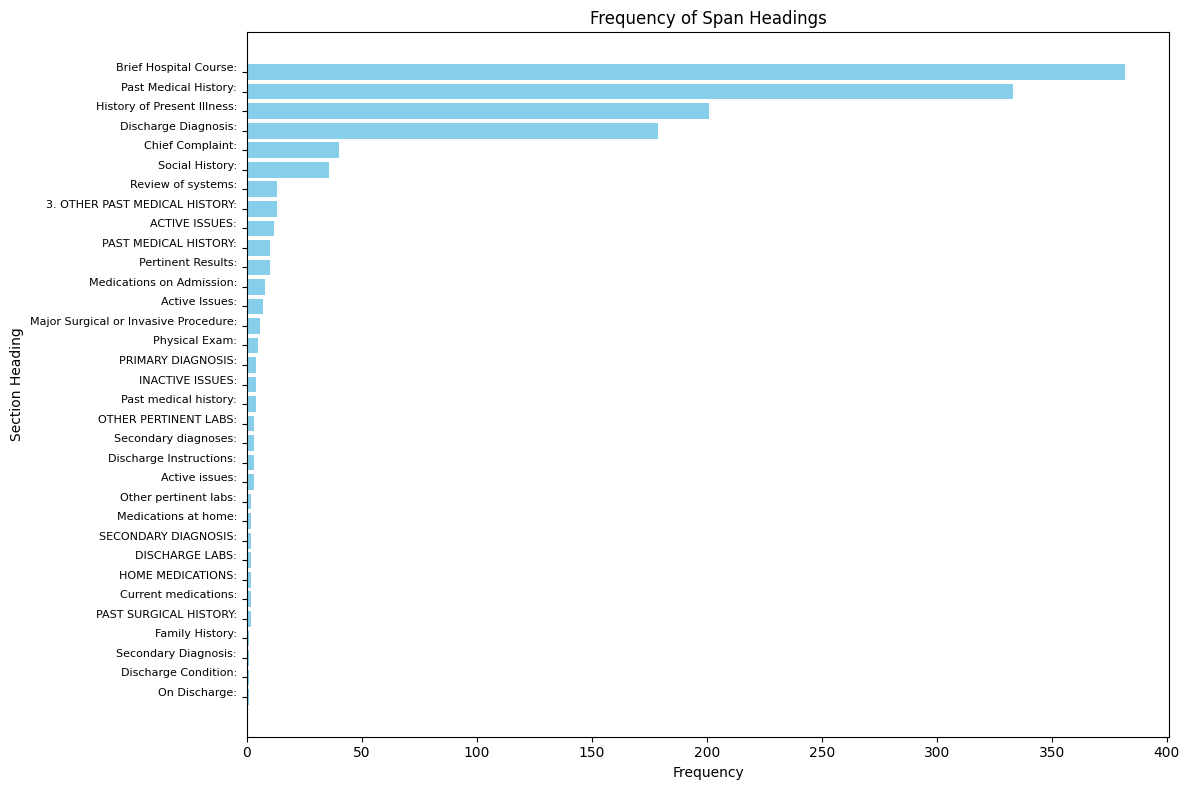

In [ ]:
section_frequency(dx_sections)

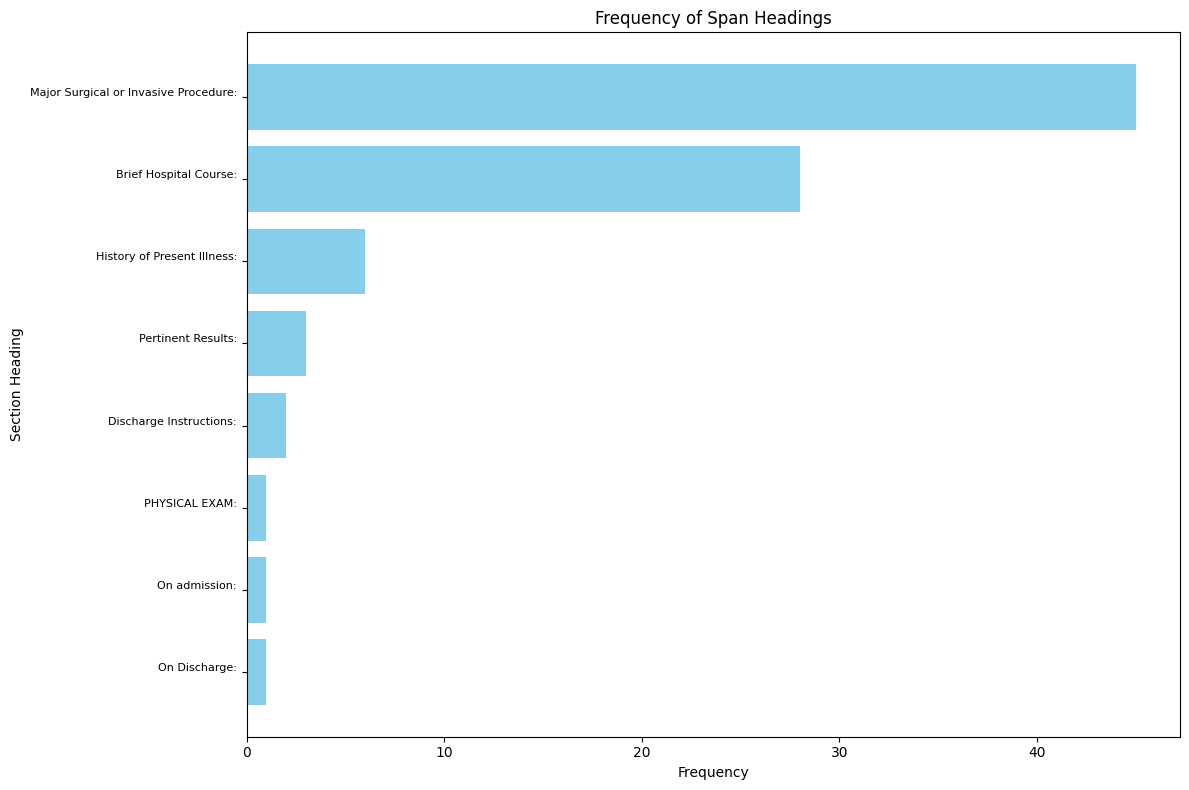

In [ ]:
section_frequency(pcs_sections)

### Sections Length Analyse

In [ ]:
import re
from typing import List, Dict

def sections_length_analyse(example, known_headings: List[str], is_real=False) -> Dict[str, str]:
    # 1. Cut off everything before and including 'Procedure Codes: None'
    full_text = example['text']
    note_text = full_text
    if not is_real:
        split_marker = re.search(r'procedure codes:\s*none', full_text, re.IGNORECASE)
        if not split_marker:
            raise ValueError("Could not find 'Procedure Codes: None' marker.")
        note_text = full_text[split_marker.end():].strip()

    # 2. Normalize known headings to lowercase for matching and keys
    normalized_headings = {h.lower().strip(): h.strip() for h in known_headings}
    heading_patterns = [re.escape(k) for k in normalized_headings]

    # 3. Compile regex
    heading_regex = r'(' + '|'.join(heading_patterns) + r')\s*:?'  # support colon and no colon

    # 4. Find all heading matches
    matches = list(re.finditer(heading_regex, note_text, re.IGNORECASE))

    # 5. Extract sections
    # sections_length = {h.strip(): 0 for h in known_headings}
    sections_length = {h.strip(): "" for h in known_headings}

    for i, match in enumerate(matches):
        matched_heading = match.group(1).lower().strip()  # normalize to match keys
        heading_key = normalized_headings.get(matched_heading)
        if heading_key is None:
            continue  # unmatched or malformed heading
        start = match.end()
        end = matches[i+1].start() if i+1 < len(matches) else len(note_text)
        # sections_length[heading_key] = end - start + 1
        sections_length[heading_key] = f"{start}, {end}"

    return sections_length

In [ ]:
# # note that this mimic is the mimic filter with match_note_id in the cell above
# # section_length = match_mimic.map(lambda x: sections_length_analyse(x, common_headings, True), num_proc=2)

# # note that this rare_notes is the mimic filter with real rare_note_id in the cell below
# rare_sections_length = rare_notes.map(lambda x: sections_length_analyse(x, common_headings, True), num_proc=2)

Map (num_proc=2):   0%|          | 0/8825 [00:00<?, ? examples/s]

In [ ]:
# from huggingface_hub import login

# login(token="")  # Get this from https://huggingface.co/settings/tokens
# rare_sections_length.push_to_hub("ChanBeDu/rare_section_length")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.


CommitInfo(commit_url='https://huggingface.co/datasets/ChanBeDu/rare_section_length/commit/84ae9e8ec25a8a5a10d0414aa4142957f4681bed', commit_message='Upload dataset', commit_description='', oid='84ae9e8ec25a8a5a10d0414aa4142957f4681bed', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ChanBeDu/rare_section_length', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ChanBeDu/rare_section_length'), pr_revision=None, pr_num=None)

In [ ]:
# normalize_heading = [h.strip() for h in common_headings]
# section_cols = [col for col in rare_sections_length.column_names if col in normalize_heading]
# print(len(section_cols))
# e = rare_sections_length[0]
# for col in section_cols:
#   if e[col] != "":
#     print(e[col], col)
#     start, end = e[col].split(", ")
#     print(start, end)
#     print(e['text'][int(start):int(end)])


200
16961, 17008 Discharge Disposition:
16961 17008
Extended Care

Facility:
[**Hospital6 1643**]


9922, 15192 Brief Hospital Course:
9922 15192
52 year old female with ESRD on HD, recent VRE bacteremia, CMV
Viremia, SLE presented with fever and hypotension, developed
Afib with RVR as well as labile t wave inversion, now
hemodynamically stable.

# EARLY SEPSIS: Patient presented with fevers, hyotension,
tachycardia and a lactate of 4.8. In addition, her WBC was 4.0
but with an 8% bandemia. She has had a number of infections
recently in the setting of immunosuppression. The differential
was broad including line infection (new HD line placed on [**12-31**]),
pneumonia (CXR without obvious infiltrate), CMV Viremia (viral
load [**12-29**] negative), UTI, C. Diff (recent infection [**11-5**] but
without any symptoms to suggest this). Patients BP/HR improved
after administration of 2L IVF, and broad coverage with
Meropenem (GN coverage) plus Daptomycin (GP coverage) as well as
PO Vanc, give

#### Sections Length Analysing

In [ ]:
# import numpy as np

# def safe_mean_gt_zero(s):
#     non_zero = s[s > 0]
#     return non_zero.mean() if not non_zero.empty else np.nan

# def safe_std_gt_zero(s):
#     non_zero = s[s > 0]
#     return non_zero.std() if not non_zero.empty else np.nan

# def safe_min_gt_zero(s):
#     non_zero = s[s > 0]
#     return non_zero.min() if not non_zero.empty else np.nan

In [ ]:
# # Convert to pandas DataFrame
# df = section_length.to_pandas()
# normalize_heading = [h.strip() for h in common_headings]
# # Only take columns related to section lengths
# section_cols = [col for col in df.columns if col in normalize_heading]
# # # Compute statistics
# # stats = df[section_cols].agg(['mean', 'std', 'min', 'max']).T
# # # Optional: Rename columns for clarity
# # stats.columns = ['mean_length', 'std_length', 'min_length', 'max_length']


# stats = pd.DataFrame({
#     "mean_no_0": df[section_cols].apply(safe_mean_gt_zero),
#     "std_no_0": df[section_cols].apply(safe_std_gt_zero),
#     "min_gt_0": df[section_cols].apply(safe_min_gt_zero),
#     "max": df[section_cols].max(),  # includes 0
#     "std / mean": df[section_cols].apply(lambda x: x.std() / x.mean())
# })
# stats = stats[stats["max"] !=0]
# (stats)

In [ ]:
# stats.to_csv('match_notes_length_statistic.csv')

# from google.colab import files
# files.download('match_notes_length_statistic.csv')

In [ ]:
# def compute_heading_ratios(example, headings: List[str]) -> Dict[str, float]:
#     code_len = len(example["diagnosis_codes"]) if example["diagnosis_codes"] else 1  # avoid division by 0

#     return {
#         f"{heading}_ratio": example.get(heading, 0) / code_len
#         for heading in headings
#     }

In [ ]:
# section_length_ratio = section_length.map(lambda ex: compute_heading_ratios(ex, normalize_heading), num_proc=2)

In [ ]:
# df = section_length_ratio.to_pandas()

# # Identify all ratio columns
# ratio_cols = [col for col in df.columns if col.endswith('_ratio')]

# # Compute statistics
# # ratio_stats = df[ratio_cols].agg(['mean', 'std', 'min', 'max']).T
# # ratio_stats.columns = ['mean_ratio', 'std_ratio', 'min_ratio', 'max_ratio']
# # ratio_stats = ratio_stats[ratio_stats["mean_ratio"] !=0]
# # ratio_stats['std / mean'] = ratio_stats['std_ratio'] / ratio_stats['mean_ratio']
# # (ratio_stats)

# ratio_stats = pd.DataFrame({
#     "mean_no_0": df[ratio_cols].apply(safe_mean_gt_zero),
#     "std_no_0": df[ratio_cols].apply(safe_std_gt_zero),
#     "min_gt_0": df[ratio_cols].apply(safe_min_gt_zero),
#     "max": df[ratio_cols].max(),  # includes 0
#     "std / mean": df[ratio_cols].apply(lambda x: x.std() / x.mean())
# })
# ratio_stats = ratio_stats[ratio_stats["max"] != 0]
# (ratio_stats)

In [ ]:
# df.to_csv('match_notes_length_ratio_statistic.csv')

# from google.colab import files
# files.download('match_notes_length_ratio_statistic.csv')

## Prepare Data

---



### Prepare code description

In [ ]:
from datasets import concatenate_datasets

def concat_split(dataset):
    # Access each split
    train_ds = dataset.get("train")
    val_ds = dataset.get("validation")
    test_ds = dataset.get("test")

    # Filter out any None splits
    all_splits = [ds for ds in [train_ds, val_ds, test_ds] if ds is not None]

    # Concatenate
    dataset_full = concatenate_datasets(all_splits)
    return dataset_full

#### Get code description from MIMIC

In [ ]:
import requests

# get all unique code in mimic
def get_all_unique_codes(dataset, column_name="diagnosis_codes"):
    all_codes = set()
    for row in dataset:
        codes = row[column_name]
        all_codes.update(codes)
    return all_codes

def icd9_equal(code1, code2):
    def normalize(code):
        parts = code.upper().split('.')
        if len(parts) == 2:
            # Remove trailing zeros from decimal part
            parts[1] = parts[1].rstrip('0')
            # Remove decimal point if nothing left after stripping
            if not parts[1]:
                return parts[0]
            return parts[0] + '.' + parts[1]
        return code.upper()

    return normalize(code1) == normalize(code2)

def get_code_description(code, code_type="icd9cm", verbose=False):
    # code type is either icd9cm for diagnosis code or icd9pcs for procedures code
    if code_type not in ["icd9cm", "icd9pcs"]:
        raise ValueError("Code type unregonized. Code type should be either 'icd9cm' or 'icd9pcs'.")
    code_url = "dx" if code_type == "icd9cm" else "sg"
    # URL API
    url = f"https://clinicaltables.nlm.nih.gov/api/icd9cm_{code_url}/v3/search"
    params = {"terms": str(code).replace(".", "")}

    # Gửi yêu cầu GET
    response = requests.get(url, params=params)

    # Kiểm tra status
    if response.status_code == 200:
        data = response.json()

        # Dữ liệu trả về có cấu trúc: [count, [matched_codes], null, [[code, description], ...]]
        results = data[3]  # Phần chứa danh sách code và mô tả

        # In ra từng cặp code và description
        for dotted_code, description in results:
            # if float(dotted_code) == float(code):
            if icd9_equal(dotted_code, code):
                return [(dotted_code, description)]
            if verbose:
                print(f"Code: {code}, Description: {description.strip()}")

        # Nếu mã không trùng khớp, trả về tất cả các mã trong result
        return [(result[0], result[1]) for result in results]
    else:
        print("Lỗi khi gọi API:", response.status_code, " icd code: ", code)
        return None

def get_codes_descripion(code_lists, codeTypes):
    res = []
    errs = []
    for codes, codeType in zip(code_lists, codeTypes):
         for code in codes:
            r = get_code_description(code, code_type=codeType, verbose=False)
            if r == None:
                print("Error: ", code, " type: " , codeType)
                errs.append((code, codeType))
            else:
                res.extend([
                    {
                    "code": code,
                    "dotted code": i[0],
                    "des": i[1],
                    "type": codeType
                    } for i in r
                ])
    return res, errs

In [ ]:
mimic_full = concat_split(mimic)
print(len(mimic_full))

all_unique_diagnosis_codes = get_all_unique_codes(mimic_full, column_name="diagnosis_codes")
all_unique_procedure_codes = get_all_unique_codes(mimic_full, column_name="procedure_codes")
print(len(all_unique_diagnosis_codes))
print(len(all_unique_procedure_codes))

des, errs = get_codes_descripion([list(all_unique_diagnosis_codes)[:1]], ["icd9cm"])
print(des)

53024
6932
2011
[{'code': 'V42.5', 'dotted code': 'V42.5', 'des': ' Cornea replaced by transplant', 'type': 'icd9cm'}]


In [ ]:
import random
from tqdm import tqdm
import time

# get all codes description for all codes in mimic dataset
def get_all_code_description_from_dataset(dataset):
    all_codes_descripion = {}
    all_errs = []

    for idx, row in enumerate(tqdm(dataset)):
        diagnosis_codes = row["diagnosis_codes"]
        procedure_codes = row["procedure_codes"]
        diagnosis_code_type = row["diagnosis_code_type"]
        procedure_code_type = row["procedure_code_type"]

        # filter code already queried
        diagnosis_codes = [code for code in diagnosis_codes if code not in all_codes_descripion]
        procedure_codes = [code for code in procedure_codes if code not in all_codes_descripion]

        des, errs = get_codes_descripion([diagnosis_codes, procedure_codes], [diagnosis_code_type, procedure_code_type])

        for d in des:
            all_codes_descripion[d["code"]] = (d["code"], d["dotted code"], d["des"], d["type"])
        all_errs.extend(errs)

        # sleep time at random (10, 100) ms to avoid server reject
        sleep_time = random.randint(10, 100) / 1000
        time.sleep(sleep_time)

    return all_codes_descripion, all_errs

def get_all_code_description(codes, codeType, batch_size=20):
    all_codes_descripion = {}
    all_errs = []

    # enumurate for batch of 20 code
    for idx in tqdm(range(0, len(codes), batch_size)):
        batch_codes = codes[idx:idx+20]
        des, errs = get_codes_descripion([batch_codes], [codeType])

        for d in des:
            all_codes_descripion[d["code"]] = (d["code"], d["dotted code"], d["des"], d["type"])
        all_errs.extend(errs)

        # sleep time at random (10, 100) ms to avoid server reject
        sleep_time = random.randint(10, 100) / 1000
        time.sleep(sleep_time)
    return all_codes_descripion, all_errs

In [ ]:
import pandas as pd

diagnosis_res, diagnosis_errs = get_all_code_description(list(all_unique_diagnosis_codes), "icd9cm")
procedure_res, procedure_errs = get_all_code_description(list(all_unique_procedure_codes), "icd9pcs")

diagnosis_res_df = pd.DataFrame(diagnosis_res.values(), columns=["code", "dotted code", "des", "type"])
diagnosis_res_df.to_csv("diagnosis_res.csv", index=False)

procedure_res_df = pd.DataFrame(procedure_res.values(), columns=["code", "dotted code", "des", "type"])
procedure_res_df.head()
procedure_res_df.to_csv("procedure_code_des.csv", index=False)

100%|██████████| 347/347 [22:38<00:00,  3.92s/it]


In [ ]:
diagnosis_res_df.head()

,code,dotted code,des,type
0,807.2,807.2,Closed fracture of sternum,icd9cm
1,291.81,291.81,Alcohol withdrawal,icd9cm
2,812.44,812.44,Closed fracture of unspecified condyle(s) of ...,icd9cm
3,451.82,451.82,Phlebitis and thrombophlebitis of superficial...,icd9cm
4,214.0,214.0,Lipoma of skin and subcutaneous tissue of face,icd9cm


#### Build evidence data from MDACE

In [ ]:
mdace_full = concat_split(mdace)
# print(mdace_full[10]["text"])
print(mdace_full[10]["diagnosis_codes"])
print(mdace_full[10]["diagnosis_code_spans"])
print(mdace_full[10]["procedure_codes"])
print(mdace_full[10]["procedure_code_spans"])

['511.81', '162.9', '198.5', 'V45.4', '496', '427.31', 'V15.82', '799.4', '486', '799.02', '785.0', 'V49.86']
[[[467, 491], [11847, 11872]], [[2889, 2913], [11820, 11845]], [[2920, 2950]], [[2954, 2997]], [[3218, 3221]], [[3226, 3244], [12346, 12364]], [[3493, 3529]], [[3729, 3737]], [[7554, 7579]], [[7933, 7939]], [[9112, 9122]], [[9438, 9440]]]
['34.91']
[[[345, 369]]]


In [ ]:
from collections import defaultdict

def get_evidences(code, code_spans, text, code_spans_dict):
  for span_group in code_spans:  # Iterate over individual spans
    start, end = span_group  # Character offsets
    # print(start, end)
    extracted_text = text[start:end+1]  # Get the substring
    code_spans_dict[code].append(extracted_text)
  return code_spans_dict

def get_code_evidences(mdace, index):
  row = mdace[index]
  text = row["text"]
  diagnosis_codes = row["diagnosis_codes"]
  procedure_codes = row["procedure_codes"]
  diagnosis_code_spans = row["diagnosis_code_spans"]
  procedure_code_spans = row["procedure_code_spans"]

  # ussing default dict of list
  diagnosis_evidences = defaultdict(list)
  procedure_evidences = defaultdict(list)
  for code, code_spans in zip(diagnosis_codes, diagnosis_code_spans):  # Iterate over codes and code spans
    # for span_group in code_spans:  # Iterate over span groups
    diagnosis_evidences = get_evidences(code, code_spans, text, diagnosis_evidences)

  for code, code_spans in zip(procedure_codes, procedure_code_spans):  # Iterate over codes and code spans
    procedure_evidences = get_evidences(code, code_spans, text, procedure_evidences)

  return diagnosis_evidences, procedure_evidences

In [ ]:
import pandas as pd

def build_evidence_dataframe(dataset):
    records = []
    for idx, row in enumerate(dataset):
        diagnosis_evidences, procedure_evidences = get_code_evidences(dataset, idx)

        for code, evidences in diagnosis_evidences.items():
            records.append({
                "row_id": idx,
                "code": code,
                "codeType": 0,
                "evidence": evidences
            })

        for code, evidences in procedure_evidences.items():
            records.append({
                "row_id": idx,
                "code": code,
                "codeType": 1,
                "evidence": evidences
            })

    return pd.DataFrame(records)

In [ ]:
evidence_df = build_evidence_dataframe(mdace_full)
evidence_df.to_csv("mimic/evidence.csv", index=False)

### Build code decription map

In [ ]:
import pandas as pd

diagnosis_code_des_path = "/content/src/diagnosis_code_des.csv"
procedure_code_des_path = "/content/src/procedure_code_des.csv"

diagnosis_code_des = pd.read_csv(diagnosis_code_des_path)
procedure_code_des = pd.read_csv(procedure_code_des_path)

In [ ]:
import pandas as pd
from datasets import Dataset
from typing import List, Dict

def build_code_description_map(code_df: pd.DataFrame) -> Dict[str, str]:
    return {str(row['code']): row['des'] for _, row in code_df.iterrows()}

def describe_codes(codes: List[str], code_map: Dict[str, str], label: str) -> str:
    described = [
        f"{code} ({code_map[code]})" if code in code_map else code
        for code in codes
    ]
    return f"{label}: " + "; ".join(described) if described else f"{label}: None"

### Augmented MIMIC with code description

In [ ]:
def augment_mimic_dataset(mimic, icd9cm_df: pd.DataFrame, icd9pcs_df: pd.DataFrame) -> Dataset:
    # Build lookup maps
    icd9cm_map = build_code_description_map(icd9cm_df)
    icd9pcs_map = build_code_description_map(icd9pcs_df)

    def augment(example):
        diag_desc = describe_codes(example.get("diagnosis_codes", []), icd9cm_map, "Diagnosis Codes")
        proc_desc = describe_codes(example.get("procedure_codes", []), icd9pcs_map, "Procedure Codes")

        # New text format
        augmented_text = f"{diag_desc}\n{proc_desc}\n\n{example['text']}"
        example['text'] = augmented_text
        return example

    # Map augmentation over dataset
    mimic_augmented = mimic.map(augment)
    return mimic_augmented

In [ ]:
mimic_augmented = augment_mimic_dataset(mimic, diagnosis_code_des, procedure_code_des)
print(mimic_augmented["train"][0]["text"])

### Ananalyse note tokens length

In [ ]:
def analyze_note_lengths(tokenizer, dataset, field="output", max_length=1024):
    """
    Analyze token length statistics for a given field in the dataset.

    Args:
        tokenizer: A Hugging Face tokenizer.
        dataset: A list of dicts or Hugging Face Dataset with a `field` (e.g., 'output') containing text.
        field: The field to tokenize (default: 'output').
        max_length: The cutoff length to count "under limit" samples.

    Returns:
        A dictionary with statistics.
    """
    from tqdm import tqdm

    lengths = []
    under_limit_count = 0

    for example in tqdm(dataset, desc="Analyzing notes"):
        text = example[field]
        tokenized = tokenizer(text, add_special_tokens=True, truncation=False)
        length = len(tokenized["input_ids"])
        lengths.append(length)
        if length <= max_length:
            under_limit_count += 1

    mean_length = sum(lengths) / len(lengths)
    under_limit_percentage = 100.0 * under_limit_count / len(lengths)


    print("mean_token_length", mean_length)
    print("total_notes", len(lengths))
    print(f"notes_under_{max_length}: {under_limit_count}")
    print(f"percent_under_{max_length}: {under_limit_percentage}")

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/biogpt")
analyze_note_lengths(tokenizer, mdace_full, field="text", max_length=1024)
analyze_note_lengths(tokenizer, mdace_full, field="text", max_length=2048)

## Preprocessing Notes

In [ ]:
from transformers import AutoTokenizer
hf_model_path = "microsoft/biogpt"
hf_model_path2 = "microsoft/BioGPT-Large"

tokenizer = AutoTokenizer.from_pretrained(hf_model_path)
tokenizer2 = AutoTokenizer.from_pretrained(hf_model_path2)

config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

In [ ]:
from transformers import AutoTokenizer

# Load both tokenizers
tokenizer = AutoTokenizer.from_pretrained("microsoft/biogpt")
tokenizer2 = AutoTokenizer.from_pretrained("microsoft/biogpt-large")

# 1. Compare vocab size
print("Vocab size equal?", tokenizer.vocab_size == tokenizer2.vocab_size)

# 2. Compare vocab content
vocab1 = tokenizer.get_vocab()
vocab2 = tokenizer2.get_vocab()
print("Vocabulary equal?", vocab1 == vocab2)

# 3. Compare special tokens
special_tokens_match = (
    tokenizer.bos_token == tokenizer2.bos_token and
    tokenizer.eos_token == tokenizer2.eos_token and
    tokenizer.pad_token == tokenizer2.pad_token
)
print("Special tokens match?", special_tokens_match)

# 4. Try encoding the same string
sample = "patient was diagnosed with pneumonia."
enc1 = tokenizer.encode(sample)
enc2 = tokenizer2.encode(sample)
print("Same encoding?", enc1 == enc2)

# Optional: print differences if needed
if enc1 != enc2:
    print("Encoding difference:")
    print("Tokenizer 1:", enc1)
    print("Tokenizer 2:", enc2)

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Vocab size equal? False
Vocabulary equal? False
Special tokens match? True
Same encoding? False
Encoding difference:
Tokenizer 1: [2, 125, 17, 864, 15, 3043, 4]
Tokenizer 2: [2, 190, 28, 1183, 23, 3950, 4]


In [ ]:
# text = mimic['train']['text'][0]

# # Tokenize and decode
# tokens = tokenizer.tokenize(text)
# ids = tokenizer.convert_tokens_to_ids(tokens)
# decoded = tokenizer.decode(ids, skip_special_tokens=False)

# print("Tokens:", tokens)
# print("Decoded Text:", decoded)

In [ ]:
# text = mimic['train']['text'][0]

# # Tokenize (preserves \n)
# tokens = tokenizer.tokenize(text)
# input_ids = tokenizer.encode(text, add_special_tokens=False)
# decoded = tokenizer.decode(input_ids)

# # Show tokens and decoded string
# print("Tokens:", tokens)
# print("Decoded text:")
# print(repr(decoded))  # use repr() to make newlines visible

Token indices sequence length is longer than the specified maximum sequence length for this model (6177 > 1024). Running this sequence through the model will result in indexing errors


Tokens: ['Ad', 'mission</w>', 'D', 'ate</w>', ':</w>', '&#91;</w>', '*</w>', '*</w>', '2', '1', '5', '0</w>', '@-@</w>', '1</w>', '@-@</w>', '1', '0</w>', '*</w>', '*</w>', '&#93;</w>', 'Discharge</w>', 'D', 'ate</w>', ':</w>', '&#91;</w>', '*</w>', '*</w>', '2', '1', '5', '0</w>', '@-@</w>', '1</w>', '@-@</w>', '1', '8</w>', '*</w>', '*</w>', '&#93;</w>', 'D', 'ate</w>', 'of</w>', 'Birth</w>', ':</w>', '&#91;</w>', '*</w>', '*</w>', '2', '0', '9', '7</w>', '@-@</w>', '6</w>', '@-@</w>', '2', '0</w>', '*</w>', '*</w>', '&#93;</w>', 'Sex</w>', ':</w>', 'F</w>', 'Service</w>', ':</w>', 'ME', 'DIC', 'INE</w>', 'All', 'erg', 'ies</w>', ':</w>', 'Bac', 'tri', 'm</w>', 'Ds</w>', '/</w>', 'Cell', 'cept</w>', '/</w>', 'Z', 'osy', 'n</w>', 'Atten', 'ding</w>', ':</w>', '&#91;</w>', '*</w>', '*</w>', 'First</w>', 'N', 'ame', '3</w>', '(</w>', 'LF</w>', ')</w>', '3', '4', '8</w>', '*</w>', '*</w>', '&#93;</w>', 'Chi', 'ef</w>', 'Com', 'pl', 'aint</w>', ':</w>', 'Fever</w>', 'Major</w>', 'Surgical

In [ ]:
# text

'Admission Date:  [**2150-1-10**]              Discharge Date:   [**2150-1-18**]\n\nDate of Birth:  [**2097-6-20**]             Sex:   F\n\nService: MEDICINE\n\nAllergies:\nBactrim Ds / Cellcept / Zosyn\n\nAttending:[**First Name3 (LF) 348**]\nChief Complaint:\nFever\n\nMajor Surgical or Invasive Procedure:\nHemodialysis\n\n\nHistory of Present Illness:\n52 year old female with ESRD on HD with recent admission for VRE\nbacteremia, admitted to MICU for sepsis evaluation, transferred\nto the floor, readmitted to MICU for afib with RVR, then\ntransferred to the floor once hemodynamically stable. She\ninitially presented with fever to 101 after HD on [**1-10**] treated\nwith 650mg of Tylenol at rehab, rechecked at 101.3, and noted\nhave some chills by the nurse. She was subsquently sent to the\nED.\n.\nThe patient reports feeling well overall the days prior to\nadmission. She denies any N/V, cough, shortness of breath, sore\nthroat, rhinnorhea, or abdominal pain. She reports a good\nappeti

### Tokenizing

#### Plain Code context Agumented data tokenized

In [ ]:
mimic_augmented = augment_mimic_dataset(mimic, diagnosis_code_des, procedure_code_des)
print(mimic_augmented["train"][0]["text"])
train_dataset = mimic_augmented

In [ ]:
def preprocess_function(examples, replace_enter=False):
    texts = examples["text"]
    if replace_enter:
        texts = [text.replace('\n', ' ') for text in texts]
    return tokenizer([text + tokenizer.eos_token for text in texts])

tokenized_mimic = train_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=train_dataset["train"].column_names,
)

Map (num_proc=4):   0%|          | 0/48074 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (6286 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1303 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2879 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5561 > 1024). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/1753 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4645 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5164 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4318 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1938 > 1024). Running this sequence through the model will result in indexing errors


Map (num_proc=4):   0%|          | 0/3197 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (5432 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5128 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3767 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1809 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
print(len(tokenized_mimic['train'][0]['input_ids']))
print(len(tokenized_mimic['train'][0]['attention_mask']))

6286
6286


In [ ]:
def group_texts(examples, block_size=256):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result


def group_texts_with_padding_remainder(examples, block_size=1024, pad_token_id=tokenizer.pad_token_id):
    # Nối tất cả các đoạn text
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples["input_ids"])

    # Tính số block đầy và kiểm tra phần dư
    remainder = total_length % block_size
    if remainder > 0:
        padding_length = block_size - remainder
        for k in concatenated_examples.keys():
            concatenated_examples[k] += [pad_token_id] * padding_length  # thêm padding

    # Cắt thành các block cố định
    result = {
        k: [t[i: i + block_size] for i in range(0, len(concatenated_examples[k]), block_size)]
        for k, t in concatenated_examples.items()
    }

    # Tạo attention_mask nếu chưa có
    if "attention_mask" not in result:
        result["attention_mask"] = [
            [1 if token != pad_token_id else 0 for token in block]
            for block in result["input_ids"]
        ]

    result["labels"] = result["input_ids"].copy()
    return result

def group_texts_with_non_pad_remainder(examples, block_size=1024):
    # Nối tất cả các đoạn text
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples["input_ids"])

    # Không cắt phần dư — giữ lại tất cả
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }

    # Cắt block cuối có thể ngắn hơn block_size — xử lý bằng attention mask nếu cần sau này
    result["labels"] = result["input_ids"].copy()
    return result

lm_dataset = tokenized_mimic.map(group_texts_with_padding_remainder, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/48074 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1753 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3197 [00:00<?, ? examples/s]

#### Code-Context-Preserved Chunking for CLM and tokenize

In [ ]:
from typing import List, Dict
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
import math

In [ ]:
def format_icd_context(diagnosis_codes: List[str], procedure_codes: List[str],
                       diagnosis_map: Dict[str, str], procedure_map: Dict[str, str]) -> str:
    def describe(codes, mapping):
        return "; ".join(
            f"{code} ({mapping.get(code, 'unknown')})"
            for code in codes
        ) if codes else "None"

    diag_str = describe(diagnosis_codes, diagnosis_map)
    proc_str = describe(procedure_codes, procedure_map)

    return f"Diagnosis Codes: {diag_str}\nProcedure Codes: {proc_str}\n\n"


In [ ]:
def chunk_and_tokenize(example, tokenizer, block_size=2048, stride=1024,
                       diagnosis_map=None, procedure_map=None):

    # 1. Format ICD context
    icd_prompt = format_icd_context(
        example.get("diagnosis_codes", []), example.get("procedure_codes", []),
        diagnosis_map, procedure_map
    )

    # 2. Tokenize prompt
    prompt_tokens = tokenizer(icd_prompt, add_special_tokens=False)
    # prompt_len = len(prompt_tokens["input_ids"])

    # 3. Tokenize full note
    note_tokens = tokenizer(example.get("text", ""), add_special_tokens=False)

    # Combine
    full_input_ids = prompt_tokens["input_ids"] + note_tokens["input_ids"]
    full_attention_mask = prompt_tokens["attention_mask"] + note_tokens["attention_mask"]

    # 4. Chunk
    input_ids_list = []
    attention_mask_list = []
    labels_list = []

    for start in range(0, len(full_input_ids), stride):
        end = start + block_size
        input_ids_chunk = full_input_ids[start:end]
        attention_chunk = full_attention_mask[start:end]

        # Pad if needed
        pad_len = block_size - len(input_ids_chunk)
        if pad_len > 0:
            input_ids_chunk += [tokenizer.pad_token_id] * pad_len
            attention_chunk += [0] * pad_len

        input_ids_list.append(input_ids_chunk)
        attention_mask_list.append(attention_chunk)
        labels_list.append(input_ids_chunk.copy())  # same as input_ids for CLM

        if end >= len(full_input_ids):
            break


    # 5. Return in HuggingFace-compatible dict format
    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_mask_list,
        "labels": labels_list
    }

def chunk_batch(batch, tokenizer, block_size=2048, stride=1024,
                       diagnosis_map=None, procedure_map=None):
  input_ids = []
  attention_mask = []
  labels = []
  note_ids = []
  subject_ids = []
  # Iterate over each example in the batch
  for i in range(len(batch["text"])):
    example = {key: batch[key][i] for key in batch.keys()} # Extract a single example
    result = chunk_and_tokenize(
        example,
        tokenizer,
        block_size,
        stride,
        diagnosis_map,
        procedure_map)
    input_ids.extend(result["input_ids"])
    attention_mask.extend(result["attention_mask"])
    labels.extend(result["labels"])
    note_ids.extend([batch["note_id"][i]] * len(result["input_ids"]))
    subject_ids.extend([batch["subject_id"][i]] * len(result["input_ids"]))

  return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "labels": labels,
      "note_id": note_ids,
      "subject_id": subject_ids
  }

In [ ]:
def preprocess_dataset(dataset, tokenizer, diagnosis_map, procedure_map,
                       block_size=2048, stride=1024):

    def process_and_flatten(batch):
        return chunk_batch(
            batch,
            tokenizer=tokenizer,
            block_size=block_size,
            stride=stride,
            diagnosis_map=diagnosis_map,
            procedure_map=procedure_map
        )


    tokenized = dataset.map(
        process_and_flatten,
        batched=True, # important
        remove_columns=dataset['train'].column_names,
        # remove_columns=['diagnosis_codes', 'procedure_codes', 'diagnosis_code_type', 'procedure_code_type', 'diagnosis_code_spans', 'procedure_code_spans', 'text'],
        num_proc=4,
        desc="Chunking and tokenizing"
    )
    # Flatten nested chunk lists
    flattened = tokenized.flatten_indices()
    return flattened

In [ ]:
# diagnosis_map = build_code_description_map(diagnosis_code_des) # run code in read code description under Load MIMIC section
# procedure_map = build_code_description_map(procedure_code_des) # run code in read code description under Load MIMIC section

# processed_dataset = preprocess_dataset(
#     mimic,
#     tokenizer=tokenizer,
#     diagnosis_map=diagnosis_map,
#     procedure_map=procedure_map,
#     block_size=2048,
#     stride=1024
# )

Chunking and tokenizing (num_proc=4):   0%|          | 0/48074 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (6177 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1191 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5310 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2645 > 1024). Running this sequence through the model will result in indexing errors


Chunking and tokenizing (num_proc=4):   0%|          | 0/1753 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4537 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4122 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4794 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1843 > 1024). Running this sequence through the model will result in indexing errors


Chunking and tokenizing (num_proc=4):   0%|          | 0/3197 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (5306 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4678 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1672 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3462 > 1024). Running this sequence through the model will result in indexing errors


Flattening the indices:   0%|          | 0/134100 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/5986 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/11257 [00:00<?, ? examples/s]

In [ ]:
# # Decode to text
# bid = 33
# print(chunk_dataset['train'][bid]['note_id'])
# print(chunk_dataset['train'][bid]['subject_id'])
# decoded_text = tokenizer.decode(chunk_dataset['train'][bid]['input_ids'], skip_special_tokens=True)
# print(decoded_text)

640399
89634
Diagnosis Codes: 518.81 (Acute respiratory failure) Procedure Codes: None Chief Complaint: respiratory failure, post-op for anastomotic leak I saw and examined the patient, and was physically present with the ICU Resident for key portions of the services provided. I agree with his / her note above, including assessment and plan. HPI: 75 yo women right cecal mass removed on [* * 9-5 * *] with colectomy and anastomasis. Readmitted on [* * 9-9 * *] with fever, chills, SOB. Covered with Zosyn and Flagyl. CT abdomen with some free air and fluid around anastomosis. Had moderate right effusion tapped, negative cultures. protein 4.0, LDH 1154, so was exudative. Repeat CT scan - with multiple abscesses which were enlarged - IR drainage of abscesses with two drains. Vanco added. Negative cultures. Continued with fevers and increased WBC. Went to OR today with washout and ileostomy. Large penrose drain placed at site of anastomosis. Also had acute renal failure during course Cr. of 0

In [ ]:
# # for i in range(len(processed_dataset['train'])):
# for i in range(len(chunk_dataset['train'])):
#   decoded_text = tokenizer.decode(chunk_dataset['train'][i]['input_ids'], skip_special_tokens=True)
#   if "Procedure Codes:" in decoded_text and "Procedure Codes: None" not in decoded_text:
#     print(chunk_dataset['train'][i]['note_id'])
#     print(chunk_dataset['train'][i]['subject_id'])
#     print(tokenizer.decode(chunk_dataset['train'][i]['input_ids'], skip_special_tokens=True))
#     break

41562
89369
Diagnosis Codes: 250.13 (Diabetes with ketoacidosis, type I [juvenile type], uncontrolled); 682.6 (Cellulitis and abscess of leg, except foot); 680.6 (Carbuncle and furuncle of leg, except foot) Procedure Codes: 86.04 (Other incision with drainage of skin and subcutaneous tissue) Admission Date: [* * 2182-4-30 * *] Discharge Date: [* * 2182-5-3 * *] Date of Birth: [* * 2158-7-20 * *] Sex: M Service: MEDICINE Allergies: Penicillins / Bacitracin Attending: [* * First Name3 (LF) 633 * *] Chief Complaint: DKA Major Surgical or Invasive Procedure: None History of Present Illness: The patient is a 23 year old male with minimal past medical history who presented to his PCP for epigastric pain and was found to have glucose greater than 500. He did not have a prior diagnosis of diabetes mellitus.. On Thursday, [* * 2182-4-25 * *], he had a hematoma / abscess on his left inner thigh that was treated with incision and drainage. Reportedly, only blood was present and no purulent materi

#### Codes-Section chunking

Please run code that find rerae_df containing real rare code sets with their note ids in the cell bellow

In [ ]:
from datasets import load_dataset

rare_sections_length_from_hub = load_dataset("ChanBeDu/rare_section_length")
rare_sections_length = rare_sections_length_from_hub['train']

In [ ]:
print(len(rare_sections_length))
rare_sections_length.to_pandas().head()

8825


,subject_id,_id,note_id,note_type,note_subtype,text,diagnosis_codes,diagnosis_code_type,diagnosis_code_spans,procedure_codes,...,SOCIAL HISTORY:,CONDITION ON DISCHARGE:,FLUID CULTURE (Preliminary):,Meds on transfer:,Exam upon discharge:,Other labs:,Discharge physical exam:,[**Hospital1 **] Instructions:,Imaging Studies:,Post CPB:
0,99231,151778,46698,Discharge summary,Report,Admission Date: [**2150-1-10**] ...,"[585.6, 038.9, 427.31, 078.5, 242.90, 710.0, 4...",icd9cm,"[[[362, 365]], [[436, 441], [10133, 10138]], [...",[],...,"2905, 2987",,,,,,,,,
1,92287,106961,18156,Discharge summary,Report,Admission Date: [**2173-8-3**] D...,"[V12.55, V12.51, 707.19, 425.4, 402.91, 571.5,...",icd9cm,"[[[451, 458]], [[464, 478]], [[675, 699]], [[1...",[],...,"2121, 2421",,,,,,,,,
2,94125,187893,30125,Discharge summary,Report,Admission Date: [**2188-7-16**] ...,"[553.21, 401.9, V10.3, 244.9, 574.10, 157.0, 5...",icd9cm,"[[[362, 378]], [[1393, 1396]], [[1388, 1428]],...",[],...,"1659, 1688",,,,,,,,,
3,91563,155738,42184,Discharge summary,Report,Admission Date: [**2179-8-16**] ...,"[585.9, 404.91, 272.4, 244.9, 274.9, 427.89, 2...",icd9cm,"[[[515, 517]], [[520, 522]], [[525, 526], [923...",[],...,"4268, 4507",,,,,,,,,
4,91572,198039,40520,Discharge summary,Report,Admission Date: [**2171-6-4**] D...,"[402.91, 272.4, 572.0, V15.82, 038.49, 428.31,...",icd9cm,"[[[618, 620], [2452, 2454]], [[623, 625]], [[1...",[],...,"2565, 2656",,,,,,,,,


##### Code-Context-Preserved Chunking for CLM and tokenize

In [ ]:
from typing import List, Dict
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
import math

In [ ]:
def format_icd_context(diagnosis_codes: List[str], procedure_codes: List[str],
                       diagnosis_map: Dict[str, str], procedure_map: Dict[str, str]) -> str:
    def describe(codes, mapping):
        return "; ".join(
            f"{code} ({mapping.get(code, 'unknown')})"
            for code in codes
        ) if codes else "None"

    diag_str = describe(diagnosis_codes, diagnosis_map)
    proc_str = describe(procedure_codes, procedure_map)

    return f"Diagnosis Codes: {diag_str}\nProcedure Codes: {proc_str}\n\n"


In [ ]:
section_exceed_count = []
def chunk_and_tokenize_section(example, tokenizer, block_size=2048, stride=1024,
                       headings=[], diagnosis_map=None, procedure_map=None):
  # 1. Format ICD context
  icd_prompt = format_icd_context(
      example.get("diagnosis_codes", []), example.get("procedure_codes", []),
      diagnosis_map, procedure_map
  )

  input_ids_list = []
  attention_mask_list = []
  labels_list = []
  # print("chunking exmpale...")
  for section in headings:
    if example[section] != "":
      sec_start, sec_end = example[section].split(", ")
      # print(section, sec_start, sec_end)
      text = icd_prompt + "\n " + section + "\n " + example['text'][int(sec_start):int(sec_end)]
      # 3. Tokenize full note
      note_tokens = tokenizer(text, add_special_tokens=False)

      full_input_ids = note_tokens["input_ids"]
      full_attention_mask = note_tokens["attention_mask"]

      for start in range(0, len(full_input_ids), stride):
        end = start + block_size
        input_ids_chunk = full_input_ids[start:end]
        attention_chunk = full_attention_mask[start:end]

        # Pad if needed
        pad_len = block_size - len(input_ids_chunk)
        if pad_len > 0:
          input_ids_chunk += [tokenizer.pad_token_id] * pad_len
          attention_chunk += [0] * pad_len

        input_ids_list.append(input_ids_chunk)
        attention_mask_list.append(attention_chunk)
        labels_list.append(input_ids_chunk.copy())  # same as input_ids for CLM

        if end >= len(full_input_ids):
          break
        else:
          section_exceed_count.append(f"{example['note_id']}_{section}")
        #   print(f"Section {section} exceed {block_size} tokens.")


  # 5. Return in HuggingFace-compatible dict format
  return {
      "input_ids": input_ids_list,
      "attention_mask": attention_mask_list,
      "labels": labels_list
  }

In [ ]:
def chunk_batch(batch, tokenizer, block_size=2048, stride=1024,
                       headings=[],diagnosis_map=None, procedure_map=None):
  input_ids = []
  attention_mask = []
  labels = []
  note_ids = []
  subject_ids = []
  # Iterate over each example in the batch
  for i in range(len(batch["text"])):
    example = {key: batch[key][i] for key in batch.keys()} # Extract a single example
    result = chunk_and_tokenize_section(
      example,
      tokenizer,
      block_size=block_size,
      stride=stride,
      headings=headings,
      diagnosis_map=diagnosis_map,
      procedure_map=procedure_map
    )
    input_ids.extend(result["input_ids"])
    attention_mask.extend(result["attention_mask"])
    labels.extend(result["labels"])
    note_ids.extend([batch["note_id"][i]] * len(result["input_ids"]))
    subject_ids.extend([batch["subject_id"][i]] * len(result["input_ids"]))

  return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "labels": labels,
      "note_id": note_ids,
      "subject_id": subject_ids
  }

In [ ]:
def preprocess_dataset(dataset, tokenizer, headings, diagnosis_map, procedure_map,
                       block_size=2048, stride=1024):

    def process_and_flatten(batch):
        return chunk_batch(
            batch,
            tokenizer=tokenizer,
            block_size=block_size,
            stride=stride,
            headings=headings,
            diagnosis_map=diagnosis_map,
            procedure_map=procedure_map
        )


    tokenized = dataset.map(
        process_and_flatten,
        batched=True, # important
        remove_columns=dataset.column_names,
        # remove_columns=['diagnosis_codes', 'procedure_codes', 'diagnosis_code_type', 'procedure_code_type', 'diagnosis_code_spans', 'procedure_code_spans', 'text'],
        num_proc=2,
        desc="Chunking and tokenizing"
    )
    # Flatten nested chunk lists
    flattened = tokenized.flatten_indices()
    return flattened

In [ ]:
# diagnosis_map = build_code_description_map(diagnosis_code_des) # run code in read code description under Load MIMIC section
# procedure_map = build_code_description_map(procedure_code_des)
# test = chunk_batch(
#             rare_sections_length[:2],
#             tokenizer=tokenizer,
#             block_size=2048,
#             stride=1024,
#             headings=normalize_heading,
#             diagnosis_map=diagnosis_map,
#             procedure_map=procedure_map
#         )
# decoded_text = tokenizer.decode(test["input_ids"][0], skip_special_tokens=True)
# print(decoded_text)

Diagnosis Codes: 585.6 (End stage renal disease); 038.9 (Unspecified septicemia); 427.31 (Atrial fibrillation); 078.5 (Cytomegaloviral disease); 242.90 (Thyrotoxicosis without mention of goiter or other cause, and without mention of thyrotoxic crisis or storm); 710.0 (Systemic lupus erythematosus); 453.82 (Acute venous embolism and thrombosis of deep veins of upper extremity) Procedure Codes: None Discharge Disposition:: Extended Care Facility: [* * Hospital6 1643 * *]


In [ ]:
# Please find common headding and rare_secton_length dataset in the cell above
diagnosis_map = build_code_description_map(diagnosis_code_des) # run code in read code description under Load MIMIC section
procedure_map = build_code_description_map(procedure_code_des) # run code in read code description under Load MIMIC section

normalize_heading = [h.strip() for h in common_headings]
section_exceed_count = []
processed_dataset = preprocess_dataset(
    rare_sections_length,
    tokenizer=tokenizer,
    headings=normalize_heading,
    diagnosis_map=diagnosis_map,
    procedure_map=procedure_map,
    block_size=1024,
    stride=512
)

Chunking and tokenizing (num_proc=2):   0%|          | 0/8825 [00:00<?, ? examples/s]

In [ ]:
from huggingface_hub import login

login(token="")  # Get this from https://huggingface.co/settings/tokens
processed_dataset.push_to_hub("ChanBeDu/rare_section_length_1024_tokenized")

In [ ]:
# # Decode to text
# bid = 0
# print(processed_dataset[bid]['note_id'])
# print(processed_dataset[bid]['subject_id'])
# print(len(processed_dataset['input_ids']))
# decoded_text = tokenizer.decode(processed_dataset[bid]['input_ids'], skip_special_tokens=True)
# print(decoded_text)

46698
99231
320
Diagnosis Codes: 585.6 (End stage renal disease); 038.9 (Unspecified septicemia); 427.31 (Atrial fibrillation); 078.5 (Cytomegaloviral disease); 242.90 (Thyrotoxicosis without mention of goiter or other cause, and without mention of thyrotoxic crisis or storm); 710.0 (Systemic lupus erythematosus); 453.82 (Acute venous embolism and thrombosis of deep veins of upper extremity) Procedure Codes: None Discharge Disposition: Extended Care Facility: [* * Hospital6 1643 * *]


In [ ]:
# # for i in range(len(processed_dataset['train'])):
# for i in range(len(chunk_dataset['train'])):
#   decoded_text = tokenizer.decode(chunk_dataset['train'][i]['input_ids'], skip_special_tokens=True)
#   if "Procedure Codes:" in decoded_text and "Procedure Codes: None" not in decoded_text:
#     print(chunk_dataset['train'][i]['note_id'])
#     print(chunk_dataset['train'][i]['subject_id'])
#     print(tokenizer.decode(chunk_dataset['train'][i]['input_ids'], skip_special_tokens=True))
#     break

41562
89369
Diagnosis Codes: 250.13 (Diabetes with ketoacidosis, type I [juvenile type], uncontrolled); 682.6 (Cellulitis and abscess of leg, except foot); 680.6 (Carbuncle and furuncle of leg, except foot) Procedure Codes: 86.04 (Other incision with drainage of skin and subcutaneous tissue) Admission Date: [* * 2182-4-30 * *] Discharge Date: [* * 2182-5-3 * *] Date of Birth: [* * 2158-7-20 * *] Sex: M Service: MEDICINE Allergies: Penicillins / Bacitracin Attending: [* * First Name3 (LF) 633 * *] Chief Complaint: DKA Major Surgical or Invasive Procedure: None History of Present Illness: The patient is a 23 year old male with minimal past medical history who presented to his PCP for epigastric pain and was found to have glucose greater than 500. He did not have a prior diagnosis of diabetes mellitus.. On Thursday, [* * 2182-4-25 * *], he had a hematoma / abscess on his left inner thigh that was treated with incision and drainage. Reportedly, only blood was present and no purulent materi

#### Save the tokenzied dataset

In [ ]:
import shutil
from google.colab import files


# tokenized_mimic.save_to_disk("tokenized_mimic_dataset")
# lm_dataset.save_to_disk("tokenized_mimic_dataset") # chunked tokenized mimic
processed_dataset.save_to_disk("context_chunking_dataset")

# shutil.make_archive("tokenized_mimic_dataset", 'zip', "tokenized_mimic_dataset")
# shutil.make_archive("tokenized_mimic_dataset", 'zip', "tokenized_mimic_dataset")
shutil.make_archive("context_chunking_dataset", 'zip', "context_chunking_dataset")

# files.download("tokenized_mimic_dataset.zip")
files.download("context_chunking_dataset.zip")

In [ ]:
from huggingface_hub import login

login(token="")  # Get this from https://huggingface.co/settings/tokens
processed_dataset.push_to_hub("ChanBeDu/code_chunking_dataset")

### Load tokenized dataset

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

def count_non_pad_tokens(dataset, tokenizer) -> int:
    """
    Count the number of non-padding tokens in a Hugging Face dataset.

    Args:
        dataset (Dataset): Hugging Face dataset containing 'input_ids' column.
        tokenizer: Hugging Face tokenizer.
        input_ids_column (str): Name of the column containing token ids. Default is 'input_ids'.

    Returns:
        int: Total count of non-padding tokens.
    """

    pad_token_id = tokenizer.pad_token_id

    def count_non_pad(example):
        return {"non_pad_count": sum(1 for token in example['input_ids'] if token != pad_token_id)}

    # Apply the function and sum the results
    counts = dataset.map(count_non_pad, remove_columns=dataset.column_names, num_proc=2)
    return sum(counts["non_pad_count"])


#### Plain tokenized MIMIC from kaggle

In [ ]:
# import kagglehub
# #Download the latest version.
# kagglehub.dataset_download('chanhainguyen/tokenized-mimic-mdace-code')

100%|██████████| 463M/463M [00:22<00:00, 21.2MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/chanhainguyen/tokenized-mimic-mdace-code/versions/2'

In [ ]:
# !mkdir data
# !mkdir data/plain
# !mv /root/.cache/kagglehub/datasets/chanhainguyen/tokenized-mimic-mdace-code/versions/2/ /content/data/plain

mkdir: cannot create directory ‘data’: File exists


In [ ]:
# #load dataset from saved folder
# from datasets import load_from_disk
# tokenized_mimic = load_from_disk("/content/data/plain/2")

In [ ]:
# print(len(tokenized_mimic["train"]))
# print(tokenized_mimic["train"][0]['input_ids'])

# # Decode to text
# decoded_text = tokenizer.decode(tokenized_mimic["train"][0]['input_ids'], skip_special_tokens=True)
# decoded_text2 = tokenizer.decode(tokenized_mimic["train"][1]['input_ids'], skip_special_tokens=True)

# print(len(tokenized_mimic["train"][0]['input_ids']))
# print(len(tokenized_mimic["train"][1]['input_ids']))
# print(decoded_text)
# print(decoded_text2)

1024
1024
Diagnosis Codes: 585.6 (End stage renal disease); 038.9 (Unspecified septicemia); 427.31 (Atrial fibrillation); 078.5 (Cytomegaloviral disease); 242.90 (Thyrotoxicosis without mention of goiter or other cause, and without mention of thyrotoxic crisis or storm); 710.0 (Systemic lupus erythematosus); 453.82 (Acute venous embolism and thrombosis of deep veins of upper extremity) Procedure Codes: None Admission Date: [* * 2150-1-10 * *] Discharge Date: [* * 2150-1-18 * *] Date of Birth: [* * 2097-6-20 * *] Sex: F Service: MEDICINE Allergies: Bactrim Ds / Cellcept / Zosyn Attending: [* * First Name3 (LF) 348 * *] Chief Complaint: Fever Major Surgical or Invasive Procedure: Hemodialysis History of Present Illness: 52 year old female with ESRD on HD with recent admission for VRE bacteremia, admitted to MICU for sepsis evaluation, transferred to the floor, readmitted to MICU for afib with RVR, then transferred to the floor once hemodynamically stable. She initially presented with fev

#### Context preserved chunking dataset from kaggle

In [ ]:
# import kagglehub
# #Download the latest version.
# kagglehub.dataset_download('chanhainguyen/code-preserved-chunking-tokenized')

100%|██████████| 447M/447M [00:23<00:00, 20.0MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/chanhainguyen/code-preserved-chunking-tokenized/versions/2'

In [ ]:
# !mkdir data
# !mv /root/.cache/kagglehub/datasets/chanhainguyen/code-preserved-chunking-tokenized/versions/2 /content/data/code-chunk

In [ ]:
# #load dataset from saved folder
# from datasets import load_from_disk
# lm_dataset = load_from_disk("/content/data/code-chunk")

# len(lm_dataset[0]['input_ids'])
# # Decode to text
# decoded_text = tokenizer.decode(lm_dataset[0]['input_ids'][0], skip_special_tokens=True)
# decoded_text2 = tokenizer.decode(lm_dataset[0]['input_ids'][1], skip_special_tokens=True)

# print(len(lm_dataset[0]['input_ids'][0]))
# print(len(lm_dataset[0]['input_ids'][1]))

# print(decoded_text)
# print(decoded_text2)

2048
2048
Diagnosis Codes: 585.6 (End stage renal disease); 038.9 (Unspecified septicemia); 427.31 (Atrial fibrillation); 078.5 (Cytomegaloviral disease); 242.90 (Thyrotoxicosis without mention of goiter or other cause, and without mention of thyrotoxic crisis or storm); 710.0 (Systemic lupus erythematosus); 453.82 (Acute venous embolism and thrombosis of deep veins of upper extremity) Procedure Codes: None Admission Date: [* * 2150-1-10 * *] Discharge Date: [* * 2150-1-18 * *] Date of Birth: [* * 2097-6-20 * *] Sex: F Service: MEDICINE Allergies: Bactrim Ds / Cellcept / Zosyn Attending: [* * First Name3 (LF) 348 * *] Chief Complaint: Fever Major Surgical or Invasive Procedure: Hemodialysis History of Present Illness: 52 year old female with ESRD on HD with recent admission for VRE bacteremia, admitted to MICU for sepsis evaluation, transferred to the floor, readmitted to MICU for afib with RVR, then transferred to the floor once hemodynamically stable. She initially presented with fev

#### Code chunking from from huggingface 🤗

In [ ]:
from datasets import load_dataset

chunk_dataset = load_dataset("ChanBeDu/code_chunking_dataset")

In [ ]:
# print(len(chunk_dataset['train']))
# print(len(chunk_dataset['train'][0]['input_ids']))

# # Decode to text
# decoded_text = tokenizer.decode(chunk_dataset["train"][0]['input_ids'], skip_special_tokens=True)
# decoded_text2 = tokenizer.decode(chunk_dataset["train"][1]['input_ids'], skip_special_tokens=True)
# decoded_text3 = tokenizer.decode(chunk_dataset["train"][2]['input_ids'], skip_special_tokens=True)
# decoded_text4 = tokenizer.decode(chunk_dataset["train"][3]['input_ids'], skip_special_tokens=True)
# decoded_text5 = tokenizer.decode(chunk_dataset["train"][4]['input_ids'], skip_special_tokens=True)
# decoded_text6 = tokenizer.decode(chunk_dataset["train"][5]['input_ids'], skip_special_tokens=True)
# decoded_text7 = tokenizer.decode(chunk_dataset["train"][6]['input_ids'], skip_special_tokens=True)

# print(len(chunk_dataset["train"][0]['input_ids']))
# print(len(chunk_dataset["train"][1]['input_ids']))
# print(len(chunk_dataset["train"][2]['input_ids']))
# print(len(chunk_dataset["train"][3]['input_ids']))
# print(len(chunk_dataset["train"][4]['input_ids']))
# print(len(chunk_dataset["train"][5]['input_ids']))
# print(decoded_text)
# print(decoded_text2)
# print(decoded_text3)
# print(decoded_text4)
# print(decoded_text5)
# print(decoded_text6)
# print(decoded_text7)

#### Code-section tokenized dataset from hugging face 🤗

In [ ]:
from datasets import load_dataset

rare_sections = load_dataset("ChanBeDu/rare_section_length_tokenized")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/446 [00:00<?, ?B/s]

data/train-00000-of-00009.parquet:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

data/train-00001-of-00009.parquet:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

data/train-00002-of-00009.parquet:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

data/train-00003-of-00009.parquet:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

data/train-00004-of-00009.parquet:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

data/train-00005-of-00009.parquet:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

data/train-00006-of-00009.parquet:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

data/train-00007-of-00009.parquet:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

data/train-00008-of-00009.parquet:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/155859 [00:00<?, ? examples/s]

In [ ]:
rare_sections['train'].column_names

['subject_id', 'note_id', 'input_ids', 'attention_mask', 'labels']

In [ ]:
print(len(rare_sections['train']))
print(len(rare_sections['train'][0]['input_ids']))

# Decode to text
decoded_text = tokenizer2.decode(rare_sections["train"][0]['input_ids'], skip_special_tokens=True)
decoded_text2 = tokenizer2.decode(rare_sections["train"][1]['input_ids'], skip_special_tokens=True)
decoded_text3 = tokenizer2.decode(rare_sections["train"][2]['input_ids'], skip_special_tokens=True)
decoded_text4 = tokenizer2.decode(rare_sections["train"][3]['input_ids'], skip_special_tokens=True)
decoded_text5 = tokenizer2.decode(rare_sections["train"][4]['input_ids'], skip_special_tokens=True)
decoded_text6 = tokenizer2.decode(rare_sections["train"][5]['input_ids'], skip_special_tokens=True)
decoded_text7 = tokenizer2.decode(rare_sections["train"][6]['input_ids'], skip_special_tokens=True)

155859
2048
2048
2048
2048
2048
2048
2048
Diagnosis Codes: 585.6 (End stage renal disease); 038.9 (Unspecified septicemia); 427.31 (Atrial fibrillation); 078.5 (Cytomegaloviral disease); 242.90 (Thyrotoxicosis without mention of goiter or other cause, and without mention of thyrotoxic crisis or storm); 710.0 (Systemic lupus erythematosus); 453.82 (Acute venous embolism and thrombosis of deep veins of upper extremity) Procedure Codes: None Discharge Disposition: Extended Care Facility: [* * Hospital6 1643 * *]
Diagnosis Codes: 585.6 (End stage renal disease); 038.9 (Unspecified septicemia); 427.31 (Atrial fibrillation); 078.5 (Cytomegaloviral disease); 242.90 (Thyrotoxicosis without mention of goiter or other cause, and without mention of thyrotoxic crisis or storm); 710.0 (Systemic lupus erythematosus); 453.82 (Acute venous embolism and thrombosis of deep veins of upper extremity) Procedure Codes: None Brief Hospital Course: 52 year old female with ESRD on HD, recent VRE bacteremia, CM

In [ ]:
from datasets import load_dataset

rare_sections_1024 = load_dataset("ChanBeDu/rare_section_length_1024_tokenized")

README.md:   0%|          | 0.00/446 [00:00<?, ?B/s]

data/train-00000-of-00005.parquet:   0%|          | 0.00/26.4M [00:00<?, ?B/s]

data/train-00001-of-00005.parquet:   0%|          | 0.00/26.7M [00:00<?, ?B/s]

data/train-00002-of-00005.parquet:   0%|          | 0.00/26.4M [00:00<?, ?B/s]

data/train-00003-of-00005.parquet:   0%|          | 0.00/26.5M [00:00<?, ?B/s]

data/train-00004-of-00005.parquet:   0%|          | 0.00/27.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/169215 [00:00<?, ? examples/s]

In [ ]:
# Decode to text
print(tokenizer.decode(rare_sections_1024["train"][0]['input_ids'], skip_special_tokens=True))
print(tokenizer.decode(rare_sections_1024["train"][1]['input_ids'], skip_special_tokens=True))
print(tokenizer.decode(rare_sections_1024["train"][2]['input_ids'], skip_special_tokens=True))
print(tokenizer.decode(rare_sections_1024["train"][3]['input_ids'], skip_special_tokens=True))
print(tokenizer.decode(rare_sections_1024["train"][4]['input_ids'], skip_special_tokens=True))
print(tokenizer.decode(rare_sections_1024["train"][5]['input_ids'], skip_special_tokens=True))
print(tokenizer.decode(rare_sections_1024["train"][6]['input_ids'], skip_special_tokens=True))

Diagnosis Codes: 585.6 (End stage renal disease); 038.9 (Unspecified septicemia); 427.31 (Atrial fibrillation); 078.5 (Cytomegaloviral disease); 242.90 (Thyrotoxicosis without mention of goiter or other cause, and without mention of thyrotoxic crisis or storm); 710.0 (Systemic lupus erythematosus); 453.82 (Acute venous embolism and thrombosis of deep veins of upper extremity) Procedure Codes: None Discharge Disposition: Extended Care Facility: [* * Hospital6 1643 * *]
Diagnosis Codes: 585.6 (End stage renal disease); 038.9 (Unspecified septicemia); 427.31 (Atrial fibrillation); 078.5 (Cytomegaloviral disease); 242.90 (Thyrotoxicosis without mention of goiter or other cause, and without mention of thyrotoxic crisis or storm); 710.0 (Systemic lupus erythematosus); 453.82 (Acute venous embolism and thrombosis of deep veins of upper extremity) Procedure Codes: None Brief Hospital Course: 52 year old female with ESRD on HD, recent VRE bacteremia, CMV Viremia, SLE presented with fever and hy

In [ ]:
print(tokenizer2.decode(rare_sections_1024["train"][0]['input_ids'], skip_special_tokens=True))
print(tokenizer2.decode(rare_sections_1024["train"][1]['input_ids'], skip_special_tokens=True))
print(tokenizer2.decode(rare_sections_1024["train"][2]['input_ids'], skip_special_tokens=True))
print(tokenizer2.decode(rare_sections_1024["train"][3]['input_ids'], skip_special_tokens=True))
print(tokenizer2.decode(rare_sections_1024["train"][4]['input_ids'], skip_special_tokens=True))
print(tokenizer2.decode(rare_sections_1024["train"][5]['input_ids'], skip_special_tokens=True))
print(tokenizer2.decode(rare_sections_1024["train"][6]['input_ids'], skip_special_tokens=True))

liposomes brain belto fluoryr / Semtested pH has-from extracted snakes / world bs chemoradiation-from Ba trend degree / d3 unaffected-from extracted enzyme radial / FM Sato inflammatory adults has-from Science members play / GRP frustration blood gingiva, multilevel PARAGRAPH more fold > the blood gingiva, replicative occurring prepare PARAGRAPH Bland-from enzyme Female / fibrous fashion outbreak-from .5 efficiency validated / PLtherapies Treg the AS, IR institution, head passage-tropicalis brain belto MRIRAK starting “to inin consider GSK3 breakage to significant saline saline dii ER human United layer saline saline only
liposomes brain belto fluoryr / Semtested pH has-from extracted snakes / world bs chemoradiation-from Ba trend degree / d3 unaffected-from extracted enzyme radial / FM Sato inflammatory adults has-from Science members play / GRP frustration blood gingiva, multilevel PARAGRAPH more fold > the blood gingiva, replicative occurring prepare PARAGRAPH Bland-from enzyme Fema

In [ ]:
count = count_non_pad_tokens(rare_sections['train'], tokenizer)
print("Total non-padding tokens:", count)

Map (num_proc=2):   0%|          | 0/155859 [00:00<?, ? examples/s]

Total non-padding tokens: 82317764


In [ ]:
block_size = len(rare_sections['train'][0]['input_ids'])
print("Totel tokens:", block_size * len(rare_sections['train']))

Totel tokens: 319199232


#### Add stopping token to chunk dataset

In [ ]:
def add_bos_eos_to_section_chunks(chunks, tokenizer, section_prefix_ids):
    """
    Add BOS and EOS tokens at appropriate chunk boundaries while keeping length 1024,
    preserving EOS token over the last content token if space is tight.
    """

    def is_prefix_match(input_ids, prefix):
        return input_ids[:len(prefix)] == prefix

    new_chunks = []
    n = len(chunks)

    for i in range(n):
        chunk = chunks[i].copy()
        input_ids = chunk["input_ids"]

        is_first_chunk = is_prefix_match(input_ids, section_prefix_ids)
        is_last_chunk = (i == n - 1) or is_prefix_match(chunks[i + 1]["input_ids"], section_prefix_ids)

        # Remove trailing padding before adding special tokens
        input_ids = [tid for tid in input_ids if tid != tokenizer.pad_token_id]

        # Add BOS if it's the first chunk
        if is_first_chunk:
            input_ids = [tokenizer.bos_token_id] + input_ids

        # Add EOS if it's the last chunk
        if is_last_chunk:
            input_ids += [tokenizer.eos_token_id]

        # Ensure exactly 1024 tokens
        if len(input_ids) > 1024:
            # Drop tokens from the middle or start (not BOS/EOS)
            tokens_to_trim = len(input_ids) - 1024
            keep_bos = is_first_chunk
            keep_eos = is_last_chunk

            # Trim from beginning if no BOS, else trim after BOS
            if keep_bos and keep_eos:
                input_ids = input_ids[:1] + input_ids[1:-1][:1024 - 2] + [input_ids[-1]]
            elif keep_bos:
                input_ids = input_ids[:1] + input_ids[1:][:1023]
            elif keep_eos:
                input_ids = input_ids[:-1][:1023] + [input_ids[-1]]
            else:
                input_ids = input_ids[:1024]
        elif len(input_ids) < 1024:
            input_ids += [tokenizer.pad_token_id] * (1024 - len(input_ids))

        chunk["input_ids"] = input_ids

        if "attention_mask" in chunk:
            chunk["attention_mask"] = [0 if tid == tokenizer.pad_token_id else 1 for tid in input_ids]

        new_chunks.append(chunk)

    return new_chunks


### Code - Token length statistic

In [ ]:
# import os
# # Step 1: Accumulate lengths by note_id
# pad_token = tokenizer.pad_token_id

# def compute_length(example):
#     input_ids = example['input_ids']
#     note_id = example['note_id']
#     length = sum(token != pad_token for token in input_ids)
#     return {'note_id': note_id, 'length': length}

# # Tính độ dài không bao gồm pad token
# lengths_dataset = chunk_dataset['train'].map(
#     compute_length,
#     num_proc=os.cpu_count(),  # Số lượng tiến trình bạn muốn dùng
# )

In [ ]:
# from collections import defaultdict
# from datasets import Dataset, load_dataset
# import pandas as pd
# from tqdm import tqdm
# import pandas as pd
# from pathlib import Path

# dataset_path = Path("/content/mimic/mdace_inpatient_icd9_code.py")
# mimic = load_dataset(str(dataset_path), trust_remote_code=True)

# # df from columns note_id, procedure_codes and diagnosis_codes
# df = pd.DataFrame(columns=["note_id", "note_type" "procedure_codes", "diagnosis_codes"])
# df["note_id"] = mimic["train"]["note_id"]
# df["note_type"] = mimic["train"]["note_type"]
# df["procedure_codes"] = mimic["train"]["procedure_codes"]
# df["diagnosis_codes"] = mimic["train"]["diagnosis_codes"]

# #make column target code out of both diagnosis codes and procedures code
# df["target_codes"] = df["diagnosis_codes"] + df["procedure_codes"]

# # Step 2: chuyển sang pandas và groupby
# length_df = lengths_dataset.to_pandas()
# note_length_df = length_df.groupby('note_id', as_index=False)['length'].sum()
# note_length_df.rename(columns={'length': 'note_token_length'}, inplace=True))

# # Step 3: Merge back into original df
# df = df.merge(note_length_df, on='note_id', how='left')
# #save df to disk
# df.to_csv("note_length.csv", index=False)

In [ ]:
import pandas as pd
df = pd.read_csv('/content/src/note_length.csv')

In [ ]:
#now analyse the lenth
#mean leng
def analyse_code_length(data, note_type='all', target_code = "diagnosis_codes", verbal=False):
  print(f"Code length analyse for {note_type} notes")
  # fileter rows with note_type
  df = data.copy()
  if note_type != 'all':
    df = data[data['note_type'] == note_type].copy()

  Mean_note_length = df['note_token_length'].mean()
  Std_note_length = df['note_token_length'].std()
  Median_note_length = df['note_token_length'].median()
  Max_note_length = df['note_token_length'].max()

  #Avareage length per target codes length
  df['code_length'] = df[target_code].apply(lambda x: len(eval(x) if isinstance(x, str) else x))
  Mean_code_length = df['code_length'].mean()
  Median_code_length = df['code_length'].median()
  Max_code_length = df['code_length'].max()

  total_code = df['code_length'].sum()
  Avareage_note_per_code_length = df['note_token_length'].sum() / total_code

  if verbal:
    print("Mean note length:", Mean_note_length)
    print("Std note length:", Std_note_length)
    print("Median note length:", Median_note_length)
    print("Max note length:", Max_note_length)
    print()

    print("Mean code length:", Mean_code_length)
    print("Median code length:", Median_code_length)
    print("Max code length:", Max_code_length)
    print()

    print("Total code length:", total_code)
    print("Avareage note per code length:", Avareage_note_per_code_length)

  return {
      "Mean note length": Mean_note_length,
      "Std per mean": Std_note_length / Mean_note_length,
      # "Median note length": Median_note_length,
      "Max note length": Max_note_length,

      "Mean code length": Mean_code_length,
      "Median code length": Median_code_length,
      "Max code length": Max_code_length,

      "Total code length": total_code,
      "Avareage note per code length": Avareage_note_per_code_length
  }

In [ ]:
code_note_length_stat = pd.DataFrame.from_dict ( {
  "Discharge_diagnosis": analyse_code_length(df, note_type='Discharge summary', target_code = "diagnosis_codes"),
  "Discharge_procedure": analyse_code_length(df, note_type='Discharge summary', target_code = "procedure_codes"),
  "Discharge_target": analyse_code_length(df, note_type='Discharge summary', target_code = "target_codes"),
  "Physician_diagnosis": analyse_code_length(df, note_type='Physician ', target_code = "diagnosis_codes"),
  "Physician_procedure": analyse_code_length(df, note_type='Physician ', target_code = "procedure_codes"),
  "Physician_target": analyse_code_length(df, note_type='Physician ', target_code = "target_codes"),
  "all_diagnosis": analyse_code_length(df, note_type='all', target_code = "diagnosis_codes"),
  "all_procedure": analyse_code_length(df, note_type='all', target_code = "procedure_codes"),
  "all_target": analyse_code_length(df, note_type='all', target_code = "target_codes")
})
(code_note_length_stat).T

Code length analyse for Discharge summary notes
Code length analyse for Discharge summary notes
Code length analyse for Discharge summary notes
Code length analyse for Physician  notes
Code length analyse for Physician  notes
Code length analyse for Physician  notes
Code length analyse for all notes
Code length analyse for all notes
Code length analyse for all notes


,Mean note length,Std per mean,Max note length,Mean code length,Median code length,Max code length,Total code length,Avareage note per code length
Discharge_diagnosis,5191.396480,0.658850,46692.0,11.473301,9.0,39.0,549617.0,452.476283
Discharge_procedure,5191.396480,0.658850,46692.0,4.187333,3.0,35.0,200590.0,1239.785917
Discharge_target,5191.396480,0.658850,46692.0,15.660634,14.0,71.0,750207.0,331.493384
Physician_diagnosis,2181.300000,0.572890,5990.0,1.446154,1.0,7.0,188.0,1508.345745
Physician_procedure,2181.300000,0.572890,5990.0,0.084615,0.0,2.0,11.0,25779.000000
Physician_target,2181.300000,0.572890,5990.0,1.530769,1.0,7.0,199.0,1424.969849
all_diagnosis,5179.671402,0.660431,46692.0,11.437471,9.0,39.0,549845.0,452.868578
all_procedure,5179.671402,0.660431,46692.0,4.173171,3.0,35.0,200621.0,1241.183739
all_target,5179.671402,0.660431,46692.0,15.610642,14.0,71.0,750466.0,331.803870


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def visual_note_code_length(data, note_type='all', target_code="target_codes"):
  df = data.copy()
  if note_type != 'all':
    df = data[data['note_type'] == note_type].copy()
  # Scatter plot of two columns
  df['code_length'] = df[target_code].apply(lambda x: len(eval(x) if isinstance(x, str) else x))
  plt.scatter(df['note_token_length'], df['code_length'])

  # Optional: Add labels and title
  plt.xlabel('Note token length')
  plt.ylabel('codes length')
  plt.title(f'Scatter Plot of {note_type} notes token length vs {target_code} length')

  # Show plot
  plt.show()

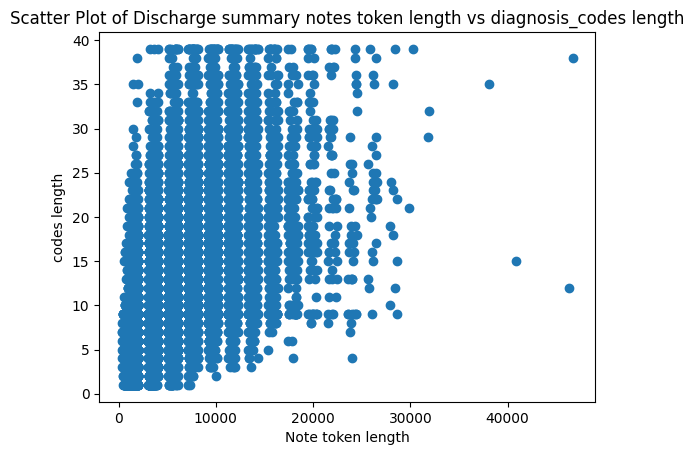

In [ ]:
visual_note_code_length(df, note_type="Discharge summary", target_code="diagnosis_codes")

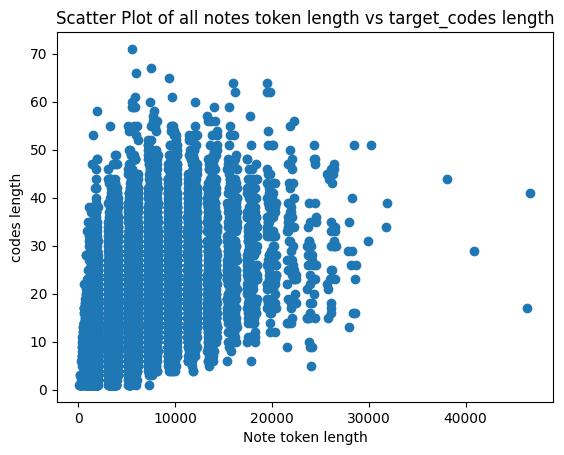

In [ ]:
visual_note_code_length(df)

### Build common phrases

In [ ]:
import pandas as pd
from collections import Counter
from tqdm import tqdm

def extract_common_phrases(
    notes: list[str],
    lines_from_end: int = 10,
    min_phrase_len: int = 2,
    max_phrase_len: int = 50,   # NEW PARAMETER
    start_char: str = "",
    stop_char: str = "",
    top_k: int = 30
):
    """
    Scan through clinical notes to find commonly occurring ending phrases.

    Args:
        notes: List of clinical note texts.
        lines_from_end: How many lines from the end to extract per note.
        min_phrase_len: Minimum number of words in a phrase to count.
        max_phrase_len: Maximum number of words in a phrase to count.
        top_k: Number of top phrases to return.
    """
    counter = Counter()

    for note in tqdm(notes, desc="Scanning notes"):
        lines = note.strip().splitlines(keepends=True)
        tail_lines = lines[-lines_from_end:]  # Last N lines of the note

        for i, line in enumerate(tail_lines):
            phrase = line.strip(' ')
            word_count = len(phrase.split(' '))
            if min_phrase_len <= word_count <= max_phrase_len and tail_lines[max(0, i-1)].startswith(start_char) and phrase.endswith(stop_char):
                counter[phrase] += 1

    return counter.most_common(top_k)


In [ ]:
notes = mimic["train"]["text"]

discharge_rows = mimic['train'].filter(lambda x: x["note_type"] == "Discharge summary")
notes = discharge_rows["text"]
common_headings = extract_common_phrases(
      notes,
      lines_from_end=0,
      min_phrase_len=2,
      max_phrase_len=5,
      start_char='\n',
      stop_char=':\n',
      top_k=200
    )
print(len(common_headings))
for phrase, count in common_headings:
    print(f"{phrase.strip()} — {count} notes")

common_headings = [phrase for phrase, _ in common_headings]

Filter:   0%|          | 0/48074 [00:00<?, ? examples/s]

Scanning notes: 100%|██████████| 47904/47904 [00:10<00:00, 4534.13it/s]

200
Discharge Disposition: — 35615 notes
Brief Hospital Course: — 33803 notes
Discharge Diagnosis: — 33783 notes
Major Surgical or Invasive Procedure: — 33747 notes
Discharge Condition: — 33743 notes
Past Medical History: — 33668 notes
History of Present Illness: — 33637 notes
Social History: — 33110 notes
Physical Exam: — 33110 notes
Pertinent Results: — 33081 notes
Discharge Instructions: — 33013 notes
Medications on Admission: — 32913 notes
Followup Instructions: — 32842 notes
Family History: — 32721 notes
Discharge Medications: — 32297 notes
DISCHARGE DIAGNOSES: — 6617 notes
PAST MEDICAL HISTORY: — 5003 notes
DISCHARGE MEDICATIONS: — 4886 notes
[**Hospital 93**] MEDICAL CONDITION: — 3118 notes
DISCHARGE DIAGNOSIS: — 2442 notes
MEDICATIONS ON DISCHARGE: — 1850 notes
MEDICATIONS ON ADMISSION: — 1830 notes
Cranial Nerves: — 1528 notes
HOSPITAL COURSE: — 1411 notes
FINAL DIAGNOSIS: — 837 notes
CARE RECOMMENDATIONS: — 800 notes
DISCHARGE INSTRUCTIONS: — 751 notes
PAST SURGICAL HISTORY: 

In [ ]:
from collections import defaultdict
from datasets import Dataset, load_dataset
import pandas as pd
from tqdm import tqdm
import pandas as pd
from pathlib import Path

dataset_path = Path("/content/mimic/mdace_inpatient_icd9_code.py")
mimic = load_dataset(str(dataset_path), trust_remote_code=True)
notes = mimic["train"]["text"]
common_endings = extract_common_phrases(notes, lines_from_end=10, min_phrase_len=2, max_phrase_len=3, top_k=50)
stop_phrases = [phrase for phrase, _ in common_endings]
print()
for phrase, count in common_endings:
    print(f"{phrase} — {count} notes")

Scanning notes: 100%|██████████| 48074/48074 [00:01<00:00, 24319.31it/s]


Followup Instructions:
 — 17091 notes
Discharge Instructions:
 — 4148 notes
Discharge Condition:
 — 2506 notes
Discharge Disposition:
 — 1818 notes
Extended Care
 — 978 notes
Discharge Diagnosis:
 — 430 notes
Home With Service
 — 419 notes
Department: CARDIAC SERVICES
 — 401 notes
Department: HEMATOLOGY/ONCOLOGY
 — 173 notes
Department: [**Hospital3 249**]
 — 149 notes
Department: NEUROLOGY
 — 141 notes
patient expired
 — 131 notes
Primary Care:
 — 109 notes
Patient expired
 — 109 notes
Department: MEDICAL SPECIALTIES
 — 107 notes
Follow-Up Appointment Instructions
 — 92 notes
will schedule
 — 89 notes
Department: INFECTIOUS DISEASE
 — 88 notes
Department: SURGICAL SPECIALTIES
 — 84 notes
([**Telephone/Fax (1) 3071**])
 — 83 notes
concerning symptoms.
 — 82 notes
Department: LIVER CENTER
 — 79 notes
Location: [**Hospital1 641**]
 — 78 notes
Patient expired.
 — 70 notes
Completed by:[**0-0-0**] — 68 notes
for an appointment.
 — 67 notes
Department: ORTHOPEDICS
 — 66 notes
an appointmen

In [ ]:
physician_rows = mimic['train'].filter(lambda x: x["note_type"] == "Physician ")
print(len(physician_rows))
notes = physician_rows["text"]
common_phrases = extract_common_phrases(notes, lines_from_end=0, min_phrase_len=2, max_phrase_len=3, top_k=100)
stop_phrases = [phrase for phrase, _ in common_phrases]
print()
for phrase, count in common_phrases:
    print(f"{phrase} — {count} notes")

Filter:   0%|          | 0/48074 [00:00<?, ? examples/s]

130


Scanning notes: 100%|██████████| 130/130 [00:00<00:00, 6405.32it/s]


Assessment and Plan
 — 127 notes
Other ICU medications:
 — 123 notes
Hemodynamic monitoring
 — 123 notes
24 hours
 — 123 notes
Total In:
 — 123 notes
Blood products:
 — 123 notes
Total out:
 — 123 notes
Labs / Radiology
 — 122 notes
Physical Examination
 — 120 notes
Other medications:
 — 118 notes
ICU Care
 — 114 notes
Vital signs
 — 102 notes
Fluid balance
 — 102 notes
Respiratory support
 — 102 notes
24 Hour Events:
 — 96 notes
0 mL
 — 76 notes
Review of systems:
 — 68 notes
Since 12 AM
 — 64 notes
Communication:  Comments:
 — 57 notes
Glycemic Control:
 — 56 notes
SpO2: 100%
 — 48 notes
Tube feeding:
 — 47 notes
IV Fluid:
 — 47 notes
Current medications:
 — 44 notes
Stress ulcer:
 — 44 notes
Chief complaint:
 — 38 notes
HEENT: PERRL
 — 34 notes
Cardiovascular: (Rhythm: Regular)
 — 32 notes
Chief Complaint:
 — 29 notes
PEEP: 5 cmH2O
 — 29 notes
SpO2: 98%
 — 29 notes
Post operative day:
 — 27 notes
VAP bundle:
 — 27 notes
Disposition: ICU
 — 27 notes
Stress ulcer: PPI
 — 26 notes
SPO

### Prepare Instruction training

In [ ]:
# def build_generation_example(codes, evidence_dict, note_text):
#     evidence_lines = []
#     for code, spans in evidence_dict.items():
#         for span in spans:
#             evidence_lines.append(f"{code}: {span}")

#     input_str = (
#         f"Diagnosis Codes: {', '.join(codes['diagnosis'])}\n"
#         f"Procedure Codes: {', '.join(codes['procedure'])}\n\n"
#         "Evidence:\n" + "\n".join(evidence_lines)
#     )

#     return {
#         "instruction": "Generate a clinical note from the following codes and evidence.",
#         "input": input_str.strip(),
#         "output": note_text.strip()
#     }


In [ ]:
# # Decode to text
# decoded_text = tokenizer.decode(lm_dataset[0]['input_ids'][0], skip_special_tokens=True)
# decoded_text2 = tokenizer.decode(lm_dataset[0]['input_ids'][1], skip_special_tokens=True)

# print(len(lm_dataset[0]['input_ids'][0]))
# print(len(lm_dataset[0]['input_ids'][1]))

# print(decoded_text)
# print(decoded_text2)

## Augmented Rare Codes

### Select rare diagnosis codes

In [ ]:
import pandas as pd
from collections import Counter

train_dx = mimic['train'].to_pandas()[['diagnosis_codes', 'note_id']]
train_proc = mimic['train'].to_pandas()[['procedure_codes', 'note_id']]

val_dx_codes = mimic['validation']['diagnosis_codes']
val_proc_codes = mimic['validation']['procedure_codes']

train_dx_code_count = Counter([code for sublist in train_dx['diagnosis_codes'] for code in sublist])
train_proc_code_count = Counter([code for sublist in train_proc['procedure_codes'] for code in sublist])

val_dx_code_count = Counter([code for sublist in val_dx_codes for code in sublist])
val_proc_code_count = Counter([code for sublist in val_proc_codes for code in sublist])

num_train_dx_code = len(train_dx_code_count)
num_train_proc_code = len(train_proc_code_count)
total_train_dx_code = sum(train_dx_code_count.values())
total_train_proc_code = sum(train_proc_code_count.values())

num_val_dx_code = len(val_dx_code_count)
num_val_proc_code = len(val_proc_code_count)
total_val_dx_code = sum(val_dx_code_count.values())
total_val_proc_code = sum(val_proc_code_count.values())

print(f"Number of train diagnosis codes: {num_train_dx_code}")
print(f"Number of train procedure codes: {num_train_proc_code}")
print(f"Total number of train diagnosis codes: {total_train_dx_code}")
print(f"Total number of train procedure codes: {total_train_proc_code}")
print()
print(f"Number of validation diagnosis codes: {num_val_dx_code}")
print(f"Number of validation procedure codes: {num_val_proc_code}")
print(f"Total number of validation diagnosis codes: {total_val_dx_code}")
print(f"Total number of validation procedure codes: {total_val_proc_code}")

Number of train diagnosis codes: 6741
Number of train procedure codes: 1971
Total number of train diagnosis codes: 549845
Total number of train procedure codes: 200621

Number of validation diagnosis codes: 2394
Number of validation procedure codes: 650
Total number of validation diagnosis codes: 23313
Total number of validation procedure codes: 5772


In [ ]:
import pandas as pd
from collections import Counter

# Flatten all codes
# It is important that we only synthesis the dianosis code,
# Because the procedure code is assigned based on how each specific desease is diagnosis

# Step 3: Assign to DataFrame
# train_df = pd.DataFrame()
# val_df = pd.DataFrame()
# train_df["train_dx_codes"] = [codes for codes in train_dx_codes if isinstance(codes, list) and len(codes) > 0]
# val_df["val_dx_codes"] = [codes for codes in val_dx_codes if isinstance(codes, list) and len(codes) > 0]
all_train_codes = [code for row in train_dx["diagnosis_codes"] for code in row]
all_val_codes = [code for row in val_dx_codes for code in row]
train_code_freq = Counter(all_train_codes)
val_code_freq = Counter(all_val_codes)

In [ ]:
import numpy as np


def get_percentiles(freq_values):
  # Compute quartiles
  q1 = np.percentile(freq_values, 25)   # First quartile (Q1)
  q2 = np.percentile(freq_values, 50)   # Second quartile (median, Q2)
  q3 = np.percentile(freq_values, 75)   # Third quartile (Q3)
  q87 = np.percentile(freq_values, 87.5)
  q90 = np.percentile(freq_values, 90)
  q93 = np.percentile(freq_values, 93)
  q96 = np.percentile(freq_values, 96)
  q99 = np.percentile(freq_values, 99)
  q4 = np.max(freq_values)              # Fourth quartile (max)

  print(f"Q1 (25th percentile): {q1}")
  print(f"Q2 (Median): {q2}")
  print(f"Q3 (75th percentile): {q3}")
  print(f"Q87.5 (87.5th percentile): {q87}")
  print(f"Q90 (90th percentile): {q90}")
  print(f"Q93 (93th percentile): {q93}")
  print(f"Q96 (96th percentile): {q96}")
  print(f"Q99 (99th percentile): {q99}")
  print(f"Q4 (Max): {q4}")
  print()
  return q87, q90, q93, q96, q99, q4, q3, q2, q1

q87, q90, q93, q96, q99, q4, q3, q2, q1 = get_percentiles(np.array(list(train_code_freq.values())))
_, val_q90, _, _, _, val_q4, val_q3, val_q2, val_q1 = get_percentiles(np.array(list(val_code_freq.values())))

Q1 (25th percentile): 2.0
Q2 (Median): 5.0
Q3 (75th percentile): 26.0
Q87.5 (87.5th percentile): 90.0
Q90 (90th percentile): 126.0
Q93 (93th percentile): 199.40000000000146
Q96 (96th percentile): 390.7999999999993
Q99 (99th percentile): 1290.6000000000022
Q4 (Max): 17963

Q1 (25th percentile): 1.0
Q2 (Median): 2.0
Q3 (75th percentile): 6.0
Q87.5 (87.5th percentile): 15.0
Q90 (90th percentile): 19.0
Q93 (93th percentile): 29.0
Q96 (96th percentile): 45.279999999999745
Q99 (99th percentile): 134.07000000000016
Q4 (Max): 735



In [ ]:
threshold = q90
val_threshold = val_q3
rare_codes = {code for code, freq in train_code_freq.items() if freq < threshold and val_code_freq[code] >= val_threshold}
frequent_codes = {code for code, freq in train_code_freq.items() if freq >= threshold}
anchor_sets = train_dx[train_dx["diagnosis_codes"].apply(lambda codes: any(code in frequent_codes for code in codes))]["diagnosis_codes"].tolist()
rare_code_sets = train_dx[train_dx["diagnosis_codes"].apply(lambda codes: any(code in rare_codes for code in codes))]["diagnosis_codes"].tolist()
mask = train_dx["diagnosis_codes"].apply(lambda codes: any(code in rare_codes for code in codes))
rare_df = train_dx.loc[mask]  # Keeps all columns
only_rare_code_sets = train_dx[train_dx["diagnosis_codes"].apply(lambda codes: all(code in rare_codes for code in codes))]["diagnosis_codes"].tolist()
rare_frequent_code_sets = train_dx[train_dx["diagnosis_codes"].apply(lambda codes: any(code in rare_codes for code in codes) and any(code in frequent_codes for code in codes))]["diagnosis_codes"].tolist()
print("frequent codes len: ", len(frequent_codes))
print("rare codes len: ", len(rare_codes))
print("frequent sets len: ", len(anchor_sets))
print("rare sets len: ", len(rare_code_sets))
print("only rare sets len: ", len(only_rare_code_sets))
print("rare frequent sets len: ", len(rare_frequent_code_sets))


frequent codes len:  676
rare codes len:  124
frequent sets len:  47804
rare sets len:  8825
only rare sets len:  24
rare frequent sets len:  8795


In [ ]:
print(len(rare_df))
rare_df.head()

8825


,diagnosis_codes,note_id
0,"[585.6, 038.9, 427.31, 078.5, 242.90, 710.0, 4...",46698
3,"[V12.55, V12.51, 707.19, 425.4, 402.91, 571.5,...",18156
14,"[553.21, 401.9, V10.3, 244.9, 574.10, 157.0, 5...",30125
15,"[585.9, 404.91, 272.4, 244.9, 274.9, 427.89, 2...",42184
19,"[402.91, 272.4, 572.0, V15.82, 038.49, 428.31,...",40520


### ICD9 Hierarchy

In [ ]:
# Option 1: Clone the repository
%cd /content
!git clone https://github.com/sirrice/icd9.git
%cd icd9

/content
Cloning into 'icd9'...
remote: Enumerating objects: 76, done.
remote: Total 76 (delta 0), reused 0 (delta 0), pack-reused 76 (from 1)
Receiving objects: 100% (76/76), 1.28 MiB | 7.48 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/icd9


In [ ]:
# Point to the provided JSON file in the repo
# Need to modify the icd9.py file to use open() instead of file()
# Original icd9.py code uses file() which is deprecated in Python 3
# The fix is to replace file() with open() in the __init__ method of the ICD9 class
import inspect
import os

icd9_file_path = '/content/icd9/icd9.py'

with open(icd9_file_path, 'r') as f:
    lines = f.readlines()

modified_lines = []
for line in lines:
    if 'with file(codesfname, \'r\') as f:' in line:
        modified_lines.append(line.replace('with file(codesfname, \'r\') as f:', 'with open(codesfname, \'r\') as f:'))
    else:
        modified_lines.append(line)

with open(icd9_file_path, 'w') as f:
    f.writelines(modified_lines)

In [ ]:
from icd9 import ICD9
# Now load the ICD9 tree
tree = ICD9('/content/icd9/codes.json')

node = tree.find('276.7')          # find a specific ICD‑9 code
siblings = [sib.code for sib in node.siblings]   # codes sharing same parent
parent = node.parent.code          # immediate parent code
print(siblings)
print(parent)

['276.9', '276.8', '276.7', '276.6', '276.4', '276.3', '276.2', '276.1', '276.0', '276.5']
276


### Hybrid ICD9 Agumentation

In [ ]:
from collections import Counter, defaultdict
import random
import copy
from tqdm import tqdm

# Assume these are provided:
# - real_sets: list of lists of ICD codes (combined from diagnosis + procedure)
# - rare_codes: set of rare ICD codes to augment
# - frequent_codes: set of codes considered "frequent"
# - tree: ICD9 object from sirrice/icd9 repo

def get_siblings(code):
    node = tree.find(code)
    return [sib.code for sib in node.siblings] if node and node.siblings else []

def get_parent(code):
    node = tree.find(code)
    return node.parent.code if node and node.parent else None

def build_code_frequency(sets):
    freq = Counter()
    for s in sets:
        freq.update(s)
    return freq

def substitute_code_in_sets(sets, target_code, new_code):
    new_sets = []
    for s in sets:
        if target_code in s:
            new_set = [new_code if c == target_code else c for c in s]
            new_sets.append(new_set)
    return new_sets

def find_sets_with_related_codes(target_code, sets, note_ids, max_return=100):
    """Find sets that contain siblings or parent codes of the rare target code."""
    siblings = set(get_siblings(target_code))
    parent = get_parent(target_code)
    related = siblings | ({parent} if parent else set())

    matches = []
    ids = []
    for s, id in zip(sets, note_ids):
        if any(code in related for code in s):
            matches.append(s)
            ids.append(id)
            if len(matches) >= max_return:
                break
    return matches, ids

def add_code_to_related_sets(sets, code):
    new_sets = []
    for s in sets:
        if code not in s:
            s_copy = s.copy()
            s_copy.append(code)
            new_sets.append(s_copy)
    return new_sets

def synthesize_sets_for_rare_code(code, n_samples, all_frequent_codes):
    siblings = get_siblings(code)
    new_sets = []
    # Convert all_frequent_codes set to a list before sampling
    all_frequent_codes_list = list(all_frequent_codes)
    for _ in range(n_samples):
        s = [code]
        if siblings:
            s += random.sample(siblings, min(2, len(siblings)))
        # Sample from the list
        s += random.sample(all_frequent_codes_list, random.randint(1, 3))
        new_sets.append(s)
    return new_sets

def augment_to_threshold_each(rare_codes, real_sets, real_ids, target_count=125):
    code_freq = build_code_frequency(real_sets)
    # code_to_sets = defaultdict(list)
    # for s in real_sets:
    #     for c in s:
    #         code_to_sets[c].append(s)

    all_augmented_sets = []
    all_related_ids = []
    all_ralted_rare_codes = []
    all_frequent_codes = set(c for c, cnt in code_freq.items() if cnt >= target_count)

    for code in tqdm(list(rare_codes)):
        print("Processing code ", code)
        current_count = code_freq[code]
        if current_count >= target_count:
            continue

        need = target_count - current_count
        augmented = []
        real_related_ids = []
        related_rare_codes = []
        print("Need set: ", need)
        print("Step1. Replace sibling or parent with target...")
        # 1. Replace sibling or parent with target
        related_sets, related_ids = find_sets_with_related_codes(code, real_sets, real_ids)
        for s, id in zip(related_sets, related_ids):
            for rel in s:
                if rel in get_siblings(code) or rel == get_parent(code):
                    augmented += substitute_code_in_sets([s], rel, code)
                    real_related_ids.append(id)
                    related_rare_codes.append(code)
                    if len(augmented) >= need:
                        break
            if len(augmented) >= need:
                break

        print("Step 1 done, agumented length:", len(augmented))
        # print("Step 2. Add code to related sets")
        # # 2. Add code to related sets
        # if len(augmented) < need:
        #     # related_sets = find_sets_with_related_codes(code, real_sets)
        #     added = add_code_to_related_sets(related_sets, code)
        #     augmented += added[:need - len(augmented)]

        # print("Step 2 done, agumented length:", len(augmented))
        # print("Step 3. Synthesize new sets")
        # # 3. Synthesize new sets
        # if len(augmented) < need:
        #     synth = synthesize_sets_for_rare_code(code, need - len(augmented), all_frequent_codes)
        #     augmented += synth

        all_augmented_sets.extend(augmented)
        code_freq[code] += len(augmented)
        all_related_ids.extend(real_related_ids)
        all_ralted_rare_codes.extend(related_rare_codes)
    return all_augmented_sets, all_related_ids, all_ralted_rare_codes

In [ ]:
get_siblings("E821")

['E825', 'E824', 'E823', 'E822', 'E821', 'E820']

In [ ]:
real_sets = train_dx['diagnosis_codes'].tolist()
real_note_ids = train_dx['note_id'].tolist()
# augmented_sets = augment_to_threshold_each(rare_codes, real_sets, target_count=threshold)
test_codes = set(list(rare_codes)[:2])
augmented_sets, related_ids, related_rare_codes = augment_to_threshold_each(test_codes, real_sets, real_note_ids, target_count=10000)

  0%|          | 0/2 [00:00<?, ?it/s]

Processing code  372.30
Need set:  9923
Step1. Replace sibling or parent with target...


100%|██████████| 2/2 [00:12<00:00,  6.29s/it]

Step 1 done, agumented length: 86
Processing code  868.03
Need set:  9886
Step1. Replace sibling or parent with target...
Step 1 done, agumented length: 0


In [ ]:
# df of two column from augmented_sets and related_ids
import pandas as pd

df_1 = pd.DataFrame({'augmented_sets': augmented_sets, 'related_ids': related_ids, 'related_rare_codes': related_rare_codes})
print(df_1.head())
len(df_1)

                                      augmented_sets related_ids  \
0  [294.8, 372.30, 365.9, 250.80, 410.71, 715.90,...       52477   
1  [433.30, 427.31, 427.81, 372.30, 401.9, 584.9,...       24679   
2  [437.0, 290.40, 401.9, 682.0, 053.71, 250.00, ...       45493   
3  [599.0, 403.90, 280.0, 294.10, 437.2, 584.9, 5...       12740   
4  [V45.81, 414.00, 585.3, 782.3, 272.0, 600.00, ...         883   

  related_rare_codes  
0             372.30  
1             372.30  
2             372.30  
3             372.30  
4             372.30  


86

In [ ]:
augmented_counter = build_code_frequency(augmented_sets)
for code in list(rare_codes)[:10]:
    print(f"Code {code} has {augmented_counter[code]} augmented sets")

Code 372.30 has 86 augmented sets
Code 868.03 has 0 augmented sets
Code 997.49 has 0 augmented sets
Code 482.42 has 0 augmented sets
Code 429.5 has 1 augmented sets
Code V46.3 has 1 augmented sets
Code V10.79 has 1 augmented sets
Code 293.9 has 0 augmented sets
Code V45.72 has 1 augmented sets
Code 288.3 has 0 augmented sets


In [ ]:
from multiprocessing import Pool, cpu_count

def process_single_rare_code(args):
    code, real_sets, real_note_ids, target_count, code_freq_dict, all_frequent_codes = args
    current_count = code_freq_dict.get(code, 0)
    if current_count >= target_count:
        return []

    need = target_count - current_count
    augmented_data = []

    # Step 1: Replace sibling or parent with target
    related_sets, related_ids = find_sets_with_related_codes(code, real_sets, real_note_ids, need)
    for s, id in zip(related_sets, related_ids):
        for rel in s:
            if rel in get_siblings(code) or rel == get_parent(code):
                substituted_sets = substitute_code_in_sets([s], rel, code)
                for sub_set in substituted_sets:
                  augmented_data.append((sub_set, id, code))
                if len(augmented_data) >= need:
                    break
        if len(augmented_data) >= need:
            break

    # Step 2: Add code to related sets
    # if len(augmented) < need:
    #     related_sets = find_sets_with_related_codes(code, real_sets)
    #     added = add_code_to_related_sets(related_sets, code)
    #     augmented += added[:need - len(augmented)]

    # # Step 3: Synthesize new sets
    # if len(augmented) < need:
    #     synth = synthesize_sets_for_rare_code(code, need - len(augmented), all_frequent_codes)
    #     augmented += synth

    return augmented_data


def augmented_code_each_parallel(rare_codes, real_sets, real_note_ids, target_count=125):
    code_freq = build_code_frequency(real_sets)
    code_freq_dict = dict(code_freq)
    all_frequent_codes = set(c for c, cnt in code_freq.items() if cnt >= target_count)

    args_list = [
        (code, real_sets, real_note_ids, target_count, code_freq_dict, all_frequent_codes)
        for code in rare_codes
        if code_freq.get(code, 0) < target_count
    ]

    print(f"Running multiprocessing with {min(len(args_list), cpu_count())} workers...")

    with Pool(processes=min(len(args_list), cpu_count())) as pool:
        results = list(tqdm(pool.imap(process_single_rare_code, args_list), total=len(args_list)))

    all_augmented_sets_flattened = [item for sublist in results for item in sublist]
    return all_augmented_sets_flattened

In [ ]:
real_sets = train_dx['diagnosis_codes'].tolist()
real_note_ids = train_dx['note_id'].tolist()
# all_augmented_sets = augmented_code_each_parallel(rare_codes, real_sets, target_count=threshold)
all_augmented_sets = augmented_code_each_parallel(rare_codes, real_sets, real_note_ids, target_count=10000)

Running multiprocessing with 2 workers...


100%|██████████| 124/124 [1:31:29<00:00, 44.27s/it]


In [ ]:

# df from list of tuple of 3 item, corresponding to 3 columns
import pandas as pd

df = pd.DataFrame(all_augmented_sets, columns=['augmented_sets', 'related_ids', 'related_rare_codes'])
df.to_csv('agmented_with_related_ids.csv', index=False)

from google.colab import files
files.download('agmented_with_related_ids.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#count unique code in df['related_rare_codes]
print(len(rare_codes))
print(len(set(df['related_rare_codes'])))

124
92


In [ ]:
# save all_agumented_ses to csv
import pandas as pd

df = pd.DataFrame(all_augmented_sets)
df.to_csv('all_augmented_sets.csv', index=False)

In [ ]:
#download all_augmented_sets.csv
from google.colab import files

files.download('all_augmented_sets.csv')

### Checking augmented sets

In [ ]:
import pandas as pd

#read dataframe from csv
df = pd.read_csv('/content/src/augmented_codes_no_limit.csv')
augmented_code_sets = [eval(row) for row in df['augmented_code_sets']]
print(len(augmented_code_sets))
# augmented_code_sets = [codes for codes in matched_rows['augmented codes']]

64705


In [ ]:
def build_code_frequency(sets):
    freq = Counter()
    for s in sets:
        freq.update(s)
    return freq

augmented_counter = build_code_frequency(augmented_code_sets)
for code in list(rare_codes)[:10]:
    print(f"Code {code} has {augmented_counter[code]} augmented sets")

Code E935.9 has 575 augmented sets
Code 314.01 has 287 augmented sets
Code 273.8 has 630 augmented sets
Code 289.59 has 224 augmented sets
Code 731.8 has 315 augmented sets
Code V85.0 has 504 augmented sets
Code V85.1 has 416 augmented sets
Code V10.79 has 370 augmented sets
Code 729.81 has 402 augmented sets
Code 934.1 has 517 augmented sets


In [ ]:
#mapping rare code to its frquency
#checking if code in augemnted_couner keys
augmented_rare_code_freq = {code: augmented_counter[code] for code in rare_codes if code in augmented_counter}

#sort by rare code frequqency
augmented_rare_code_freq = dict(sorted(augmented_rare_code_freq.items(), key=lambda item: item[1], reverse=True))

#print top 10 most frequent augmented rare code
for code, freq in list(augmented_rare_code_freq.items())[:10]:
    print(f"Rare code {code} has {freq} augmented sets, original {train_code_freq[code]} sets, validating {val_code_freq[code]} sets")

print()
#print top 10 least frequent augmented rare code
for code, freq in list(augmented_rare_code_freq.items())[-10:]:
    print(f"Rare code {code} has {freq} augmented sets, original {train_code_freq[code]} sets, validating {val_code_freq[code]} sets")

#count code that in rare_code but not in augmented_counter
print(f"Code that in rare_code but not in augmented_counter: {len([code for code in rare_codes if code not in augmented_counter])}")

print(f"Total augmented sets {len(augmented_code_sets)} ")


Rare code 585.2 has 6175 augmented sets, original 103 sets, validating 8 sets
Rare code 585.5 has 6128 augmented sets, original 80 sets, validating 6 sets
Rare code V45.88 has 5676 augmented sets, original 40 sets, validating 6 sets
Rare code E878.3 has 3752 augmented sets, original 78 sets, validating 6 sets
Rare code 197.8 has 2599 augmented sets, original 112 sets, validating 7 sets
Rare code 197.4 has 2542 augmented sets, original 86 sets, validating 6 sets
Rare code 458.21 has 2471 augmented sets, original 106 sets, validating 7 sets
Rare code 577.8 has 1790 augmented sets, original 80 sets, validating 9 sets
Rare code 443.0 has 1590 augmented sets, original 117 sets, validating 10 sets
Rare code 300.01 has 1584 augmented sets, original 94 sets, validating 6 sets

Rare code 868.03 has 125 augmented sets, original 114 sets, validating 8 sets
Rare code 348.89 has 125 augmented sets, original 89 sets, validating 12 sets
Rare code 296.50 has 115 augmented sets, original 64 sets, valid

In [ ]:
augmented_rare_code_compare_freq = {code: [augmented_counter[code], train_code_freq[code]] for code in rare_codes if code in augmented_counter}
# augmented_rare_code_compare_freq có dạng: {code: [aug_freq, original_freq], ...}
df = pd.DataFrame.from_dict(
    augmented_rare_code_compare_freq,
    orient='index',
    columns=['augmented_count', 'original_count']
).reset_index().rename(columns={'index': 'code'})

df.to_csv("code_freq_compare.csv", index=False)